### import packages

In [1]:
import os
import sys
import abc
import random
import math
import copy
from collections import deque, namedtuple
from typing import List, Tuple
import attr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.optimize import fsolve, minimize


# Determine the project root directory (adjust the path as necessary)
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../../../..'))
print(project_root)
sys.path.append(project_root)


c:\Users\Thomas Gausmann\sciebo - Gausmann, Thomas (t_gaus04@uni-muenster.de)@uni-muenster.sciebo.de\Masterarbeit\price_simulator


In [2]:
sys.version

'3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)]'

#### Citations for Used Packages

This notebook uses the following packages:

1. **NumPy**  
   Harris, C. R., Millman, K. J., van der Walt, S. J., et al. (2020). Array programming with NumPy. *Nature*, 585(7825), 357–362. https://doi.org/10.1038/s41586-020-2649-2

2. **Matplotlib**  
   Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. *Computing in Science & Engineering*, 9(3), 90–95. https://doi.org/10.1109/MCSE.2007.55

3. **PyTorch**  
   Paszke, A., Gross, S., Massa, F., et al. (2019). PyTorch: An Imperative Style, High-Performance Deep Learning Library. *Advances in Neural Information Processing Systems*, 32, 8024–8035. https://papers.nips.cc/paper/9015-pytorch-an-imperative-style-high-performance-deep-learning-library

4. **TensorDict and TorchRL**  
   TorchRL Documentation. https://pytorch.org/rl/

5. **Keras**  
   Chollet, F., & others. (2015). Keras. https://keras.io

6. **SciPy**  
   Virtanen, P., Gommers, R., Oliphant, T. E., et al. (2020). SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python. *Nature Methods*, 17, 261–272. https://doi.org/10.1038/s41592-019-0686-2

7. **Seaborn**  
   Waskom, M. L. (2021). seaborn: statistical data visualization. *Journal of Open Source Software*, 6(60), 3021. https://doi.org/10.21105/joss.03021

8. **Attr**  
   Hynek Schlawack. attrs: Classes Without Boilerplate. https://www.attrs.org

9. **Random**  
   Python Standard Library. https://docs.python.org/3/library/random.html

10. **ABC (Abstract Base Classes)**  
    Python Standard Library. https://docs.python.org/3/library/abc.html

11. **Deque**  
    Python Standard Library. https://docs.python.org/3/library/collections.html#collections.deque


## Algorithm Related

### Simple Strategies

In [3]:
@attr.s
class AgentStrategy(metaclass=abc.ABCMeta):
    """Top-level interface for Price setting agents"""

    marginal_cost: float = attr.ib(default=1.0)
    quality: float = attr.ib(default=2.0)

    @marginal_cost.validator
    def check_marginal_costs(self, attribute, value):
        if not value >= 0.0:
            raise ValueError("Marginal costs must be positive")

    @quality.validator
    def check_quality_costs(self, attribute, value):
        if not self.marginal_cost <= value:
            raise ValueError("Quality must be at least as high as marginal costs to be active in market")

    @abc.abstractmethod
    def play_price(self, state, action_space, n_period, t):
        raise NotImplementedError

    @abc.abstractmethod
    def learn(
        self,
        previous_reward: float,
        reward: float,
        previous_action: float,
        action: float,
        action_space: List,
        previous_state: Tuple,
        state: Tuple,
        next_state: Tuple,
    ):
        raise NotImplementedError

    def who_am_i(self) -> str:
        return type(self).__name__


#### Always Defect Agent

In [4]:
@attr.s
class AlwaysDefectAgent(AgentStrategy):
    """Agent that always defects"""

    def play_price(self, state: Tuple, action_space: List, n_period: int, t: int):
        """Always play the lowest possible price."""
        return min(action_space)

    def learn(
        self,
        previous_reward: float,
        reward: float,
        previous_action: float,
        action: float,
        action_space: List,
        previous_state: Tuple,
        state: Tuple,
        next_state: Tuple,
    ):
        pass


#### Always Max Price

In [5]:
@attr.s
class AlwaysMaxAgent(AlwaysDefectAgent):
    """Agent that always plays maximum price"""

    def play_price(self, state: Tuple, action_space: List, n_period: int, t: int):
        """Always play the highest possible price."""
        return max(action_space)

#### TitForTat Agent

In [6]:
@attr.s
class TitForTat(AlwaysDefectAgent):
    """
    Tit for Tat Agent.

    If opponent undercut last period play lowest price.
    Otherwise play opponent last periods price.
    Agent must be second in list. Only two agents possible.

    """

    def play_price(self, state: Tuple, action_space: List, n_period: int, t: int):
        if state[0] < state[1]:
            return min(action_space)
        else:
            return state[0]

#### Follower Agent

In [7]:
@attr.s
class Follower(AlwaysDefectAgent):
    """
    Always plays the minimum price of last period.
    Agent must be last in list.
    
    """

    def play_price(self, state: Tuple, action_space: List, n_period: int, t: int):
        competitor_actions = state[:-1]
        min_competitor = int(np.where(np.array(action_space) == min(competitor_actions))[0])
        
        return action_space[min_competitor]

In [8]:
@attr.s
class RandomAgent(AlwaysDefectAgent):
    """Agent that plays random prices"""

    def play_price(self, state: Tuple, action_space: List, n_period: int, t: int):
        return random.choice(action_space)

### Policies (Exploration)

In [9]:
@attr.s
class ExplorationStrategy(metaclass=abc.ABCMeta):
    """Top-level interface for Exploration decision."""

    def who_am_i(self) -> str:
        return type(self).__name__

    def epsilon(self, length: int, time: int) -> float:
        raise NotImplementedError

    def explore(self, n_period: int, t: int) -> bool:
        epsilon = self.epsilon(n_period, t)
        return random.choices([True, False], weights=[epsilon, 1 - epsilon])[0]


#### Constant Epsilon

In [10]:
@attr.s
class EpsilonGreedy(ExplorationStrategy):
    """Exploration decision based on fixed epsilon greedy policy."""

    eps: float = attr.ib(default=0.1)

    @eps.validator
    def check_epsilon(self, attribute, value):
        if not 0 <= value <= 1:
            raise ValueError("Epsilon must lie in [0,1]")

    def who_am_i(self) -> str:
        return type(self).__name__ + " ({})".format(self.eps)

    def epsilon(self, length: int, time: int) -> float:
        return self.eps

#### Decreasing Epsilon

In [11]:
@attr.s
class DecreasingEpsilonGreedy(ExplorationStrategy):
    """
    Exploration decision with decreasing epsilon.
    Adapts dynamically to different simulation lengths

    """

    beta: float = attr.ib(default=0.015)

    def epsilon(self, length: int, time: int) -> float:
        """Returns epsilon for time step, such that after half of the time epsilon is 0.001"""
        return (self.beta ** (1.0 / (length / 2))) ** time


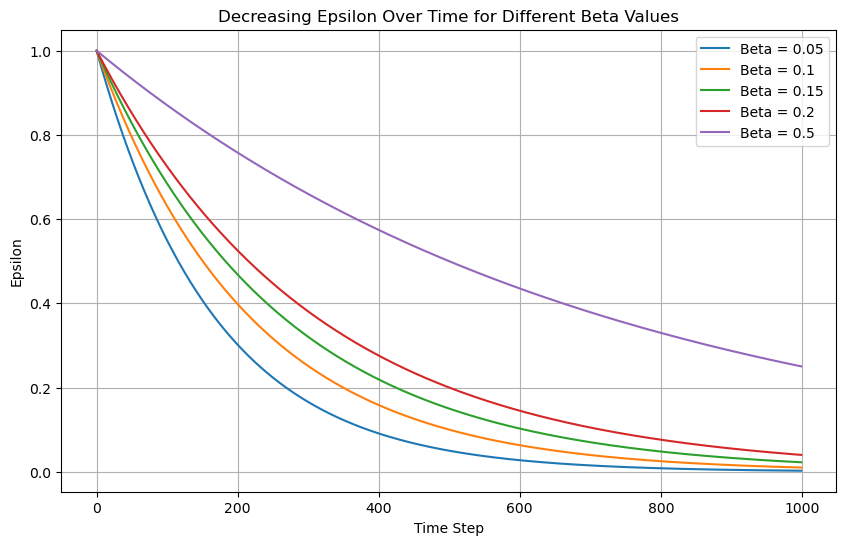

In [12]:
# Define different beta values
beta_values = [0.05, 0.1, 0.15, 0.2, 0.5]

# Define the number of periods and time steps
n_periods = 1000
time_steps = range(n_periods)

# Plot the decreasing epsilon for each beta value
plt.figure(figsize=(10, 6))
for beta in beta_values:
	# Initialize the DecreasingEpsilonGreedy instance
	decreasing_epsilon = DecreasingEpsilonGreedy(beta=beta)
	
	# Calculate epsilon values for each time step
	epsilon_values = [decreasing_epsilon.epsilon(n_periods, t) for t in time_steps]
	
	# Plot the epsilon values
	plt.plot(time_steps, epsilon_values, label=f"Beta = {beta}")

# Add plot details
plt.title("Decreasing Epsilon Over Time for Different Beta Values")
plt.xlabel("Time Step")
plt.ylabel("Epsilon")
plt.legend()
plt.grid()
plt.show()

## Economic Environment
### Demand


In [13]:
@attr.s
class MarketDemandStrategy(metaclass=abc.ABCMeta):
    """Top-level interface for all market demand modulation."""

    @abc.abstractmethod
    def get_quantities(self, prices: Tuple, qualities: Tuple) -> Tuple:
        """Return demand quanities for each price"""
        raise NotImplementedError()


#### Logit Demand

In [14]:
@attr.s
class LogitDemand(MarketDemandStrategy):
    """Market demand modulation for logit demand"""

    price_sensitivity: float = attr.ib(0.25)  # lower more sensitive
    outside_quality: float = attr.ib(0.0)

    @price_sensitivity.validator
    def check_price_sensitivity(self, attribute, value):
        if not 0.005 <= value:
            raise ValueError("Price Sensitivity must lie above 0.005")

    def get_quantities(self, prices: Tuple, qualities: Tuple) -> Tuple:
        denominator = sum((math.exp((a - p) / self.price_sensitivity) for a, p in zip(qualities, prices))) + math.exp(
            self.outside_quality / self.price_sensitivity
        )
        return tuple(math.exp((a - p) / self.price_sensitivity) / denominator for a, p in zip(qualities, prices))


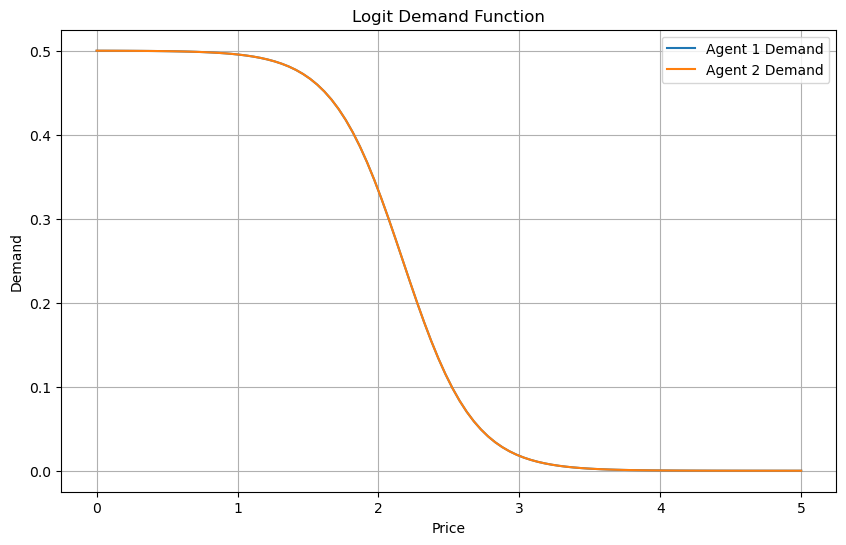

In [15]:
# Define the qualities and price range
qualities = (2, 2)
price_range = np.linspace(0, 5, 100)  # Vary prices from 0 to 5

# Initialize the LogitDemand instance
logit_demand = LogitDemand(price_sensitivity=0.25, outside_quality=0.0)

# Calculate demand for each price combination
demands = []
for price in price_range:
	demands.append(logit_demand.get_quantities((price, price), qualities))

# Extract demands for each agent
agent_1_demand = [d[0] for d in demands]
agent_2_demand = [d[1] for d in demands]

# Plot the demand curves
plt.figure(figsize=(10, 6))
plt.plot(price_range, agent_1_demand, label="Agent 1 Demand")
plt.plot(price_range, agent_2_demand, label="Agent 2 Demand")
plt.title("Logit Demand Function")
plt.xlabel("Price")
plt.ylabel("Demand")
plt.legend()
plt.grid()
plt.show()

In [16]:
print(LogitDemand().get_quantities((0, sys.float_info.max), (1, 1)))
print(LogitDemand().get_quantities((0, 1), (1, 1)))

(0.9820137900379085, 0.0)
(0.9646631559719039, 0.01766842201404805)


### Equilibrium

In [17]:
@attr.s
class EquilibriumCalculator(object):
    """Find equilibrium (Monopoly and Nash) for market environment specified by marginal costs, qualities and demand."""

    demand: MarketDemandStrategy = attr.ib()

    def get_nash_equilibrium(self, qualities: List, marginal_costs: List) -> np.array:
        """Calculate prices that makes market outcome an equilibrium"""
        param = (qualities, marginal_costs)
        p0 = np.array(marginal_costs)
        return fsolve(self.vector_reaction, p0, args=param)

    def profit(
        self, own_price: float, prices: np.array, qualities: np.array, marginal_costs: np.array, i: int
    ) -> float:
        """Calculate profit for ith firm if it sets his price to own_price given competitor prices."""
        temp_prices = copy.deepcopy(prices)
        temp_prices[i] = own_price
        return -1 * (temp_prices[i] - marginal_costs[i]) * self.demand.get_quantities(temp_prices, qualities)[i]

    def reaction_function(self, prices: np.array, qualities: np.array, marginal_costs: np.array, i: float) -> float:
        """Get price (optimal reaction) that maximizes own profit for given competitor prices."""
        return minimize(
            fun=self.profit,
            x0=np.array(marginal_costs[i]),
            args=(prices, qualities, marginal_costs, i),
            method="nelder-mead",
            options={"xatol": 1e-8},
        ).x[0]

    def vector_reaction(self, nash_prices: np.array, qualities: np.array, marginal_costs: np.array) -> np.array:
        """Vector representation of the fix-point for Nash prices."""
        return np.array(nash_prices) - np.array(
            [self.reaction_function(nash_prices, qualities, marginal_costs, i) for i in range(len(nash_prices))]
        )

    def get_monopoly_outcome(self, qualities: List, marginal_costs: List) -> np.array:
        """Get prices that maximize joint profit."""
        return minimize(
            fun=self.joint_profit,
            x0=np.array(qualities),
            args=(qualities, marginal_costs),
            method="nelder-mead",
            options={"xatol": 1e-8},
        ).x

    def joint_profit(self, prices: np.array, qualities: np.array, marginal_costs: np.array) -> float:
        """Return (negative) joint profit for prices."""
        return -1 * np.sum(
            np.multiply(np.subtract(prices, marginal_costs), self.demand.get_quantities(prices, qualities))
        )


### Storage

In [18]:
@attr.s
class Storage:
    counter = attr.ib(default=0)
    update_steps = attr.ib(init=False)
    running_rewards = attr.ib(init=False)
    running_quantities = attr.ib(init=False)
    running_actions = attr.ib(init=False)
    average_rewards = attr.ib(default=None)
    average_quantities = attr.ib(default=None)
    average_actions = attr.ib(default=None)

    def set_up(self, n_agents: int, n_periods: int, desired_length: int = 1000):
        self.reset_running_storage(n_agents)
        self.update_steps = max(1, np.round(n_periods / desired_length, 0))

    def reset_running_storage(self, n_agents: int):
        self.running_rewards = np.array([0] * n_agents)
        self.running_quantities = np.array([0] * n_agents)
        self.running_actions = np.array([0] * n_agents)

    def observe(self, rewards: np.array, actions: np.array, quantities: np.array):
        self.counter += 1
        self.running_rewards = self.incremental_update(rewards, self.running_rewards, self.counter)
        self.running_quantities = self.incremental_update(quantities, self.running_quantities, self.counter)
        self.running_actions = self.incremental_update(actions, self.running_actions, self.counter)

        if self.counter == self.update_steps:
            if self.average_actions is not None:
                self.average_rewards = np.vstack([self.average_rewards, self.running_rewards])
                self.average_actions = np.vstack([self.average_actions, self.running_actions])
                self.average_quantities = np.vstack([self.average_quantities, self.running_quantities])
            else:
                self.average_rewards = copy.deepcopy(self.running_rewards)
                self.average_actions = copy.deepcopy(self.running_actions)
                self.average_quantities = copy.deepcopy(self.running_quantities)

            self.reset_running_storage(len(rewards))
            self.counter = 0

    @staticmethod
    def incremental_update(observation: np.array, average: np.array, cnt: int) -> np.array:
        return average + (observation - average) / cnt

    def print(self):
        print("Rewards:", self.average_rewards)
        print("Prices:", self.average_actions)
        print("Quantities:", self.average_quantities)


### Environment

In [19]:
import seaborn as sns

@attr.s
class EnvironmentStrategy(metaclass=abc.ABCMeta):
    """Top-level interface for Environment."""

    agents: List[AgentStrategy] = attr.ib(factory=list)
    possible_prices: List[float] = attr.ib(factory=list)
    demand: MarketDemandStrategy = attr.ib(factory=LogitDemand)
    nash_prices: np.array = attr.ib(init=False)
    monopoly_prices: np.array = attr.ib(init=False)

    def __attrs_post_init__(self):
        """Compute Nash Price and Monopoly price after initialization."""
        if len(self.agents) > 0.0:
            marginal_costs = [agent.marginal_cost for agent in self.agents]
            qualities = [agent.quality for agent in self.agents]
            self.monopoly_prices = EquilibriumCalculator(demand=self.demand).get_monopoly_outcome(
                qualities, marginal_costs
            )
            self.nash_prices = EquilibriumCalculator(demand=self.demand).get_nash_equilibrium(
                qualities, marginal_costs
            )

    @abc.abstractmethod
    def play_game(self):
        raise NotImplementedError


@attr.s
class DiscreteSynchronEnvironment(EnvironmentStrategy):
    """Environment for discrete states and prices.

     Before the first iteration, prices are randomly initialized.
     Agents set prices at the same time.
     After choosing prices, demand and rewards are calculated.
     Then agents have the opportunity to learn.
     """

    n_periods: int = attr.ib(default=1)
    markup: float = attr.ib(default=0.1)
    n_prices: int = attr.ib(default=15)
    convergence_after: int = attr.ib(default=np.inf)
    history_after: int = attr.ib(default=np.inf)
    price_history: List = attr.ib(factory=list)
    quantity_history: List = attr.ib(factory=list)
    reward_history: List = attr.ib(factory=list)
    storage: Storage = attr.ib(factory=Storage)

    @n_periods.validator
    def check_n_periods(self, attribute, value):
        if not 0 < value:
            raise ValueError("Number of periods must be strictly positive")

    @markup.validator
    def check_markup(self, attribute, value):
        if not 0 <= value:
            raise ValueError("Price markup must be positive")

    @n_prices.validator
    def check_n_prices(self, attribute, value):
        if not 0 < value:
            raise ValueError("Number of prices must be strictly positive")

    def play_game(self) -> int:

        qualities = tuple(agent.quality for agent in self.agents)
        marginal_costs = tuple(agent.marginal_cost for agent in self.agents)

        # initialize first rounds
        if len(self.possible_prices) == 0:
            self.possible_prices = self.get_price_range(
                min(self.nash_prices), max(self.monopoly_prices), self.markup, self.n_prices
            )
        previous_state = tuple(random.choices(self.possible_prices, k=len(self.agents)))
        state = tuple(
            agent.play_price(previous_state, self.possible_prices, self.n_periods, 0) for agent in self.agents
        )
        quantities = self.demand.get_quantities(state, qualities)
        previous_rewards = np.multiply(np.subtract(state, marginal_costs), quantities)

        # set up storage
        self.storage.set_up(len(self.agents), self.n_periods)

        for t in range(self.n_periods):
            # Progress indicator
            if t % (self.n_periods // 4) == 0:
                print(f"Period {t}/{self.n_periods}")
                
            # agents decide about there prices (hereafter is the state different)
            next_state = tuple(
                agent.play_price(state, self.possible_prices, self.n_periods, t) for agent in self.agents
            )

            # demand is estimated for prices
            quantities = self.demand.get_quantities(next_state, qualities)
            rewards = np.multiply(np.subtract(next_state, marginal_costs), quantities)

            # assert that everything is correct
            assert (np.array(quantities) >= 0.0).all(), "Quantities cannot be negative"
            assert (np.array(next_state) >= 0.0).all(), "Prices cannot be negative"

            # agents learn
            for agent, action, previous_action, reward, previous_reward in zip(
                self.agents, next_state, state, rewards, previous_rewards
            ):
                agent.learn(
                    previous_reward=previous_reward,
                    reward=reward,
                    previous_action=previous_action,
                    action=action,
                    action_space=self.possible_prices,
                    previous_state=previous_state,
                    state=state,
                    next_state=next_state,
                )

            # update variables
            previous_state = copy.deepcopy(state)
            state = copy.deepcopy(next_state)
            previous_rewards = copy.deepcopy(rewards)

            # save prices for the last periods
            if t > self.history_after:
                self.price_history.append(previous_state)
                self.quantity_history.append(quantities)
                self.reward_history.append(rewards)

            # Fill storage
            self.storage.observe(rewards, state, quantities)

        return t
    
    def show_price_matrix_heatmap(self):
        """Display a heatmap with the best response prices for each price pair."""
        import matplotlib.pyplot as plt

        self.possible_prices = self.get_price_range(
            min(self.nash_prices), max(self.monopoly_prices), self.markup, self.n_prices
        )
        price_matrix = np.zeros((len(self.possible_prices), len(self.possible_prices)))

        for i, price_1 in enumerate(self.possible_prices):
            for j, price_2 in enumerate(self.possible_prices):
                state = (price_1, price_2)
                qualities = tuple(agent.quality for agent in self.agents)
                marginal_costs = tuple(agent.marginal_cost for agent in self.agents)
                quantities = self.demand.get_quantities(state, qualities)
                rewards = np.multiply(np.subtract(state, marginal_costs), quantities)
                price_matrix[i, j] = rewards[0]  # Assuming we are interested in the reward of the first agent

        rounded_prices = [round(price, 4) for price in self.possible_prices]

        plt.figure(figsize=(10, 8))
        sns.heatmap(price_matrix, xticklabels=rounded_prices, yticklabels=rounded_prices, cmap="viridis")
        plt.title("Price Matrix Heatmap (Best Response Prices)")
        plt.xlabel("Price of Agent 2")
        plt.ylabel("Price of Agent 1")
        plt.gca().invert_yaxis()  # Ensure the y-axis starts with the lowest price

        # Mark Nash price
        nash_price_1, nash_price_2 = self.nash_prices
        nash_idx_1 = min(range(len(rounded_prices)), key=lambda i: abs(rounded_prices[i] - round(nash_price_1, 2)))
        nash_idx_2 = min(range(len(rounded_prices)), key=lambda i: abs(rounded_prices[i] - round(nash_price_2, 2)))
        plt.scatter(nash_idx_2 + 0.5, nash_idx_1 + 0.5, color='red', label='Nash Price', s=100)

        # Mark Monopoly/Cooperation price
        coop_price_1, coop_price_2 = self.monopoly_prices
        coop_idx_1 = min(range(len(rounded_prices)), key=lambda i: abs(rounded_prices[i] - round(coop_price_1, 2)))
        coop_idx_2 = min(range(len(rounded_prices)), key=lambda i: abs(rounded_prices[i] - round(coop_price_2, 2)))
        plt.scatter(coop_idx_2 + 0.5, coop_idx_1 + 0.5, color='blue', label='Cooperation/Monopoly Price', s=100)

        plt.legend(loc='upper left')
        plt.show()

    def plot_joint_profit(self):
        """Plot the joint profit function over a range of prices."""
        import matplotlib.pyplot as plt

        self.possible_prices = self.get_price_range(
            min(self.nash_prices), max(self.monopoly_prices), self.markup, self.n_prices
        )
        price_matrix = np.zeros((len(self.possible_prices), len(self.possible_prices)))
        qualities = tuple(agent.quality for agent in self.agents)
        marginal_costs = tuple(agent.marginal_cost for agent in self.agents)
        for i, price_1 in enumerate(self.possible_prices):
            for j, price_2 in enumerate(self.possible_prices):
                state = (price_1, price_2)
                joint_profit = EquilibriumCalculator(demand=self.demand).joint_profit(
                    state, qualities, marginal_costs
                )
                price_matrix[i, j] = joint_profit
        rounded_prices = [round(price, 2) for price in self.possible_prices]

        plt.figure(figsize=(10, 8))
        sns.heatmap(price_matrix, xticklabels=rounded_prices, yticklabels=rounded_prices, cmap="coolwarm")
        plt.title("Joint Profit Function")
        plt.xlabel("Price of Agent 2")
        plt.ylabel("Price of Agent 1")
        plt.gca().invert_yaxis()  # Ensure the y-axis starts with the lowest price

        # Mark Nash price
        nash_price_1, nash_price_2 = self.nash_prices
        nash_idx_1 = min(range(len(rounded_prices)), key=lambda i: abs(rounded_prices[i] - round(nash_price_1, 2)))
        nash_idx_2 = min(range(len(rounded_prices)), key=lambda i: abs(rounded_prices[i] - round(nash_price_2, 2)))
        plt.scatter(nash_idx_2 + 0.5, nash_idx_1 + 0.5, color='red', label='Nash Price', s=100)

        # Mark Monopoly/Cooperation price
        coop_price_1, coop_price_2 = self.monopoly_prices
        coop_idx_1 = min(range(len(rounded_prices)), key=lambda i: abs(rounded_prices[i] - round(coop_price_1, 2)))
        coop_idx_2 = min(range(len(rounded_prices)), key=lambda i: abs(rounded_prices[i] - round(coop_price_2, 2)))
        plt.scatter(coop_idx_2 + 0.5, coop_idx_1 + 0.5, color='blue', label='Cooperation/Monopoly Price', s=100)

        plt.legend(loc='upper left')
        plt.show()

    @staticmethod
    def get_price_range(nash_price: float, monopoly_price: float, markup: float, n_step: int) -> List:
        increase = (monopoly_price - nash_price) * markup
        return list(np.linspace(nash_price - increase, monopoly_price + increase, n_step))



qualities: [2.0, 2.0]
marginal costs: [1.0, 1.0]
Nash Prices: [1.47292666 1.47292666]
Monopoly Prices: [1.92498092 1.92498091]
possible prices: [1.427721238375683, 1.4729266643524184, 1.518132090329154, 1.5633375163058894, 1.6085429422826247, 1.6537483682593601, 1.6989537942360955, 1.744159220212831, 1.7893646461895665, 1.8345700721663019, 1.8797754981430375, 1.9249809241197728, 1.9701863500965082]
average of possible prices: 1.6989537942360955
(0.8226730878191747, 0.09394396192181376)
Best response to monopoly prices: [1.6773352444171925, 1.4541891753673566]
Best response to monopoly prices: [1.4729266643524184, 1.4729266643524184]


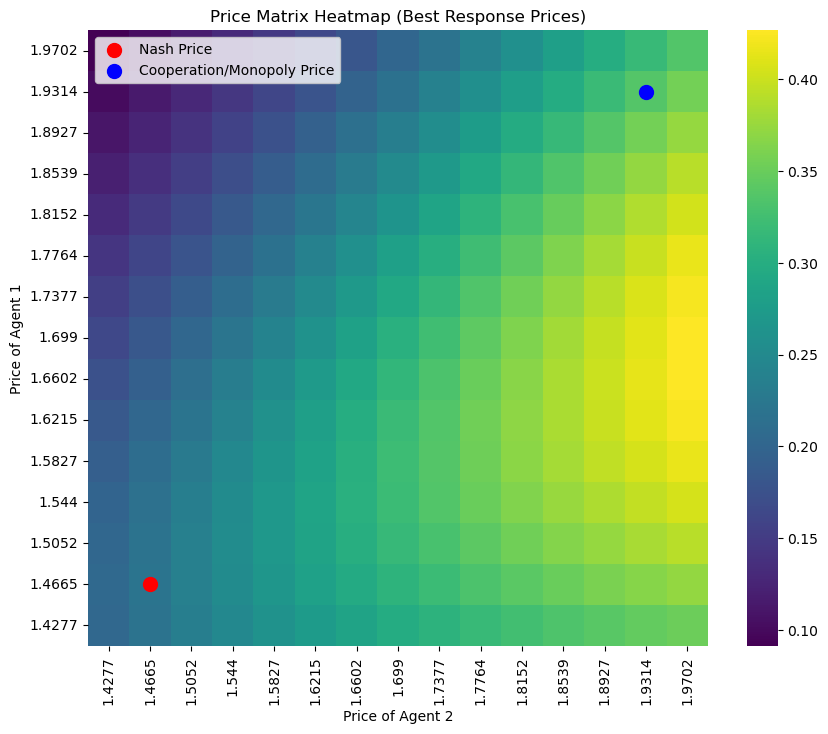

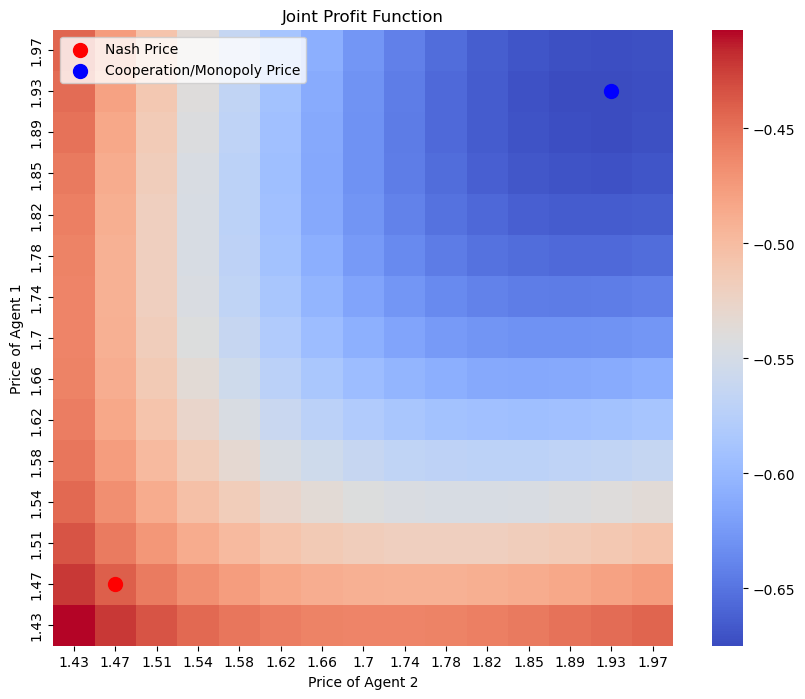

In [20]:
import seaborn as sns

# Create an environment with two AlwaysDefectAgents
env = DiscreteSynchronEnvironment(
	markup=0.1,
	n_periods=10,
	possible_prices=[],
	n_prices=15,
	demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
	history_after=100,
	agents=[
		AlwaysDefectAgent(marginal_cost=1.0, quality=2.0),
		AlwaysDefectAgent(marginal_cost=1.0, quality=2.0),
	],
)

def get_price_range_alt(nash_price: float, monopoly_price: float, markup: float, n_step: int) -> List:
    """
    Generate a range of prices that includes the Nash price and Monopoly price,
    while keeping the total number of prices to n_step.

    Args:
        nash_price (float): The Nash equilibrium price.
        monopoly_price (float): The Monopoly price.
        markup (float): The markup factor to extend the range.
        n_step (int): The total number of steps in the range.

    Returns:
        List: A list of prices including Nash and Monopoly prices.
    """
    # Calculate the initial range
    increase = (monopoly_price - nash_price) * markup
    price_range = np.linspace(nash_price - increase, monopoly_price + increase, n_step - 2)

    # Ensure Nash and Monopoly prices are included
    price_range = np.append(price_range, [nash_price, monopoly_price])

    # Sort the range to maintain order and remove duplicates
    price_range = np.unique(price_range)

    # If the range exceeds n_step, reduce it by evenly sampling
    if len(price_range) > n_step:
        price_range = np.linspace(price_range.min(), price_range.max(), n_step)

    return list(price_range)

print("qualities:", [agent.quality for agent in env.agents])
print("marginal costs:", [agent.marginal_cost for agent in env.agents])
print("Nash Prices:", env.nash_prices)
print("Monopoly Prices:", env.monopoly_prices)
possible_prices = get_price_range_alt(env.nash_prices[0], env.monopoly_prices[0], env.markup, 15)
print("possible prices:", possible_prices)
print("average of possible prices:", np.mean(possible_prices))
print(LogitDemand().get_quantities((possible_prices[0], possible_prices[-1]), [agent.quality for agent in env.agents]))


#best response prices
best_response_to_monopoly = [
    EquilibriumCalculator.reaction_function(
		self=EquilibriumCalculator(demand=env.demand),
        prices=[min(possible_prices),max(possible_prices)],
        qualities=[agent.quality for agent in env.agents],
        marginal_costs=[agent.marginal_cost for agent in env.agents],
        i=agent_idx
    )
    for agent_idx in range(len(env.monopoly_prices))
]
print("Best response to monopoly prices:", best_response_to_monopoly)
#best response prices
best_response_to_monopoly = [
    EquilibriumCalculator.reaction_function(
		self=EquilibriumCalculator(demand=env.demand),
        prices=env.nash_prices,
        qualities=[agent.quality for agent in env.agents],
        marginal_costs=[agent.marginal_cost for agent in env.agents],
        i=agent_idx
    )
    for agent_idx in range(len(env.monopoly_prices))
]
print("Best response to monopoly prices:", best_response_to_monopoly)

# Print the price matrix
env.show_price_matrix_heatmap()
env.plot_joint_profit()


In [21]:
import numpy as np
from scipy.optimize import fsolve

# Parameters
a = env.agents[0].quality
mu = env.demand.price_sensitivity
c = env.agents[0].marginal_cost
p2 = possible_prices[0]

# Define the equation to solve for p_i
def best_response_equation(p_i, p2):
    # Compute S
    S = np.exp((a - p_i) / mu) + np.exp((a - p2) / mu) + 1
    
    # Compute the derivative of profit
    term1 = np.exp((a - p_i) / mu) / S
    term2 = (p_i - c) * (1 / mu) * np.exp((a - p_i) / mu) * (np.exp((a - p_i) / mu) - S) / S**2
    return term1 + term2

for p2 in possible_prices:
    # Solve for p_i
    initial_guess = p2
    best_price = fsolve(best_response_equation, initial_guess, args=(p2))
    closest_price = min(possible_prices, key=lambda x: abs(x - best_price))

    print(f"Best response to {p2: .4f}: {best_price[0]: .4f} ({closest_price: .4f})")


Best response to  1.4277:  1.4542 ( 1.4729)
Best response to  1.4729:  1.4729 ( 1.4729)
Best response to  1.5181:  1.4921 ( 1.4729)
Best response to  1.5633:  1.5117 ( 1.5181)
Best response to  1.6085:  1.5315 ( 1.5181)
Best response to  1.6537:  1.5513 ( 1.5633)
Best response to  1.6990:  1.5709 ( 1.5633)
Best response to  1.7442:  1.5903 ( 1.6085)
Best response to  1.7894:  1.6092 ( 1.6085)
Best response to  1.8346:  1.6275 ( 1.6085)
Best response to  1.8798:  1.6451 ( 1.6537)
Best response to  1.9250:  1.6617 ( 1.6537)
Best response to  1.9702:  1.6773 ( 1.6990)


# Analyzer

In [22]:
def compute_extra_profit(pi_bar, pi_N, pi_M):
    """Computes Δ given π̅, π^N, and π^M."""
    numerator = pi_bar - pi_N
    denominator = pi_M - pi_N
    
    if denominator == 0:
        raise ValueError("Denominator cannot be zero")
    
    return numerator / denominator

## Serializer

In [23]:
import pickle


def load_object(filename):
    """ Unpickle a file of pickled data. """
    with open(filename, "rb") as f:
        return pickle.load(f)


def load_multiple_objects(filename):
    """ Stream a file of pickled objects. """
    with open(filename, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break


def save_object(obj, filename):
    """ Pickle a python object to filename.pkl . """
    with open(filename, "wb") as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


def add_object(obj, filename):
    """ Add a python object to filename.pkl . """
    with open(filename, "ab") as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


## Quick Test with 2 Always defect agents

Period 0/10
Period 2/10
Period 4/10
Period 6/10
Period 8/10


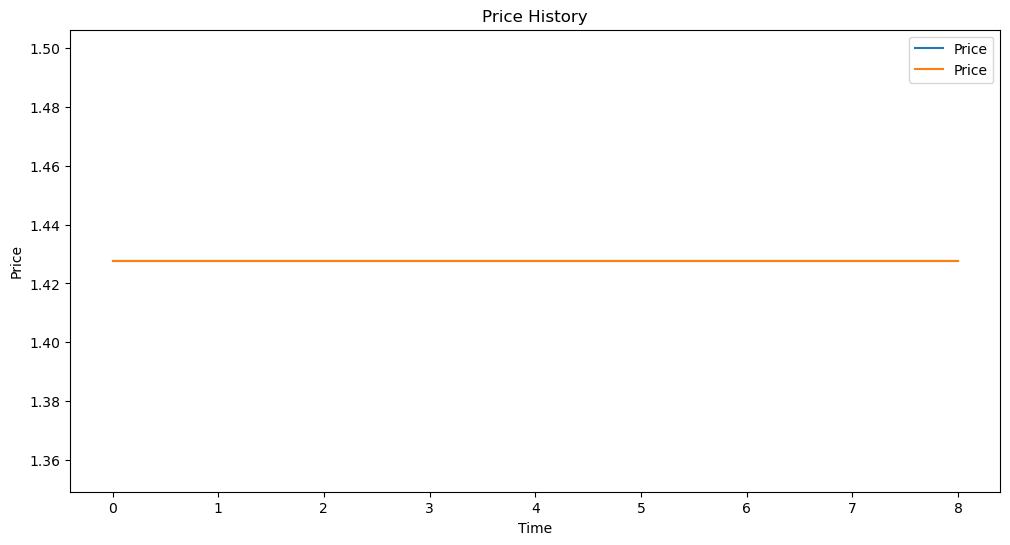

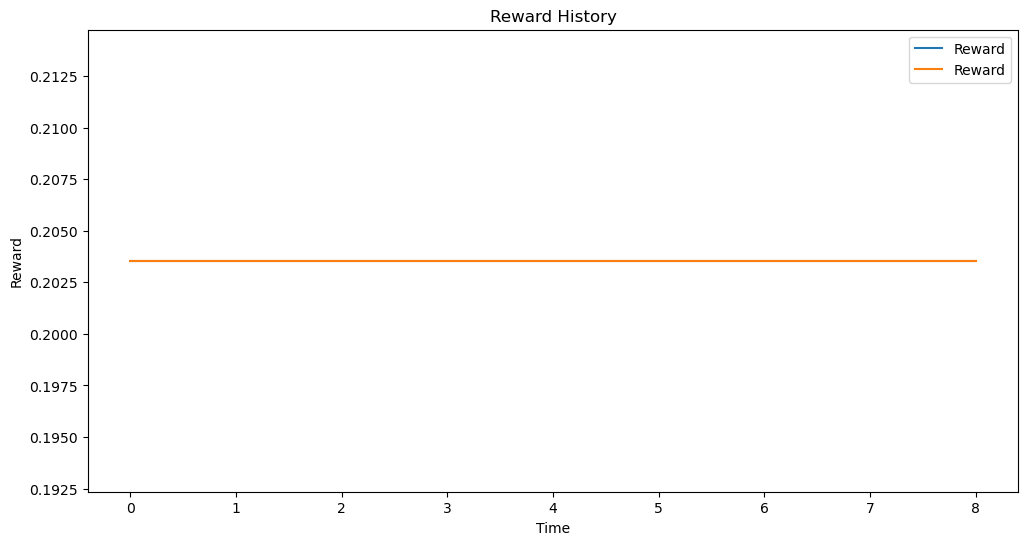

In [24]:
# Test the AlwaysDefectAgent

def create_subplot(data, label):
    for series in data:
        plt.plot(series, label=label)
    plt.legend()

def test_always_defect_agent():
    # Create an environment with AlwaysDefectAgent
    env = DiscreteSynchronEnvironment(
        markup=0.1,
        n_periods=10,
        possible_prices=[],
        n_prices=15,
        demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
        history_after=0,
        agents=[
            AlwaysDefectAgent(marginal_cost=1.0, quality=2.0),
            AlwaysDefectAgent(marginal_cost=1.0, quality=2.0),
        ],
    )

    # Simulate the environment
    env.play_game()

    # Analyze and visualize results
    price_history_1 = [price[0] for price in env.price_history]
    price_history_2 = [price[1] for price in env.price_history]

    # Plot price history
    plt.figure(figsize=(12, 6))
    create_subplot([price_history_1, price_history_2], label="Price")
    plt.title("Price History")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

    # Plot reward history
    reward_history_1 = [reward[0] for reward in env.reward_history]
    reward_history_2 = [reward[1] for reward in env.reward_history]
    plt.figure(figsize=(12, 6))
    create_subplot([reward_history_1, reward_history_2], label="Reward")
    plt.title("Reward History")
    plt.xlabel("Time")
    plt.ylabel("Reward")
    plt.show()
    

test_always_defect_agent()

# LSTM implementation

In [25]:
import attr
import torch
import random
import numpy as np
from torch import nn, optim
from typing import List, Tuple
from torchrl.data import LazyTensorStorage, TensorDictReplayBuffer, TensorDictPrioritizedReplayBuffer
from tensordict import TensorDict

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out

### Simple LSTM Agent

In [91]:

@attr.s
class SimpleLSTMAgent(AgentStrategy):
    """Simplified LSTM Agent using sequences of past states"""

    # LSTM Network
    lstm: LSTMModel = attr.ib(default=None)
    hidden_nodes: int = attr.ib(default=32)
    sequence_length: int = attr.ib(default=15)  # Number of past states to use
    state_history: np.ndarray = attr.ib(init=False, factory=lambda: np.zeros((5, 1)))
    disable_learning: bool = attr.ib(default=False)

    # General
    decision: ExplorationStrategy = attr.ib(factory=EpsilonGreedy)
    discount: float = attr.ib(default=0.95)
    learning_rate: float = attr.ib(default=0.001)

    # Debugging
    debug: bool = attr.ib(default=False)
    loss_history: List[float] = attr.ib(factory=list, init=False)

    @discount.validator
    def check_discount(self, attribute, value):
        if not 0 <= value <= 1:
            raise ValueError("Discount factor must lie in [0,1]")

    @learning_rate.validator
    def check_learning_rate(self, attribute, value):
        if not 0 <= value < 1:
            raise ValueError("Learning rate must lie in [0,1)")

    def who_am_i(self) -> str:
        return type(self).__name__ + " (gamma: {}, alpha: {}, policy: {}, quality: {}, mc: {})".format(
            self.discount, self.learning_rate, self.decision.who_am_i(), self.quality, self.marginal_cost
        )

    def update_state_history(self, state: Tuple[float]):
        """Update the history of states with the new state."""
        if self.state_history.shape[1] != len(state):
            self.state_history = np.zeros((self.sequence_length, len(state)))
        # Shift the history to the left and add the new state at the end
        self.state_history[:-1] = self.state_history[1:]
        self.state_history[-1] = np.array(state)

    def play_price(self, state: Tuple[float], action_space: List[float], n_period: int, t: int) -> float:
        """Returns an action by either following greedy policy or experimentation."""
        # Update state history
        self.update_state_history(self.scale_sequence(state, action_space))

        # Initialize LSTM network if necessary
        if not self.lstm:
            self.lstm = self.initialize_network(len(state), len(action_space))
            self.optimizer = optim.Adam(self.lstm.parameters(), lr=self.learning_rate, amsgrad=True)

        # Play action
        if self.decision.explore(n_period, t):
            chosen_action = random.choice(action_space)
            return chosen_action
        else:
            # Use state history as input to the LSTM network
            states_input = torch.tensor(self.state_history).float().unsqueeze(0)
            action_values = self.lstm(states_input).detach().numpy()
            if sum(np.isclose(action_values[0], action_values[0].max())) > 1:
                optimal_action_index = np.random.choice(
                    np.flatnonzero(np.isclose(action_values[0], action_values[0].max()))
                )
            else:
                optimal_action_index = np.argmax(action_values[0])
            chosen_action = action_space[optimal_action_index]
            return chosen_action
        
    def learn(
        self,
        previous_reward: float,
        reward: float,
        previous_action: float,
        action: float,
        action_space: List[float],
        previous_state: Tuple[float],
        state: Tuple[float],
        next_state: Tuple[float],
    ):
        """Update the LSTM network based on the observed rewards and actions."""
        if self.disable_learning:
            return
        # Update state history with the current state
        self.update_state_history(state)

        # Create a sequence of state history length for the next state
        next_state_history = self.state_history[-self.sequence_length:] + [next_state]
        # Scale the input sequences
        states_input = torch.from_numpy(self.scale_sequence(self.state_history, action_space)).float().unsqueeze(0)
        next_states_input = torch.from_numpy(self.scale_sequence(next_state_history, action_space)).float().unsqueeze(0)

        # Compute the target Q-values using the Bellman equation
        next_optimal_q = self.lstm(next_states_input).max().item()
        target = reward + self.discount * next_optimal_q

        # Get the local estimates from the LSTM network
        local_estimates = self.lstm(states_input)
        action_idx = np.atleast_1d(action_space == action).nonzero()[0]
        target_tensor = local_estimates.clone().detach()
        target_tensor[0, action_idx] = target

        # Update the LSTM network using backpropagation
        optimizer = optim.Adam(self.lstm.parameters(), lr=self.learning_rate)
        optimizer.zero_grad()
        loss = nn.MSELoss()(local_estimates, target_tensor)
        loss.backward()
        optimizer.step()
        # Store the loss value
        self.loss_history.append(loss.item())

    def initialize_network(self, n_agents: int, n_actions: int):
        """Create a neural network with one output node per possible action"""
        return LSTMModel(input_size=n_agents, hidden_size=self.hidden_nodes, output_size=n_actions)

    def scale_sequence(self, sequences: List[Tuple], action_space: List) -> np.array:
        """Scale float input sequences to range from 0 to 1."""
        max_action = max(action_space)
        min_action = min(action_space)
        return np.array([
            np.multiply(np.divide(np.array(seq) - min_action, max_action - min_action), 1) for seq in sequences
        ])
    

### RB & TN LSTM Agent

In [92]:

@attr.s
class LSTMReplayAgent(SimpleLSTMAgent):
    """LSTM Agent with Replay Buffer and Target Network"""

    # Target Network
    target_lstm: LSTMModel = attr.ib(default=None, init=False)  # Target network
    use_soft_update: bool = attr.ib(default=True)  # Use soft update for target network
    update_counter: int = attr.ib(default=0, init=False)  # Counter for target updates
    update_target_after: int = attr.ib(default=250)
    TAU: float = attr.ib(default=0.01)  # Soft update parameter

    # Replay Buffer
    replay_buffer_capacity: int = attr.ib(default=500)
    batch_size: int = attr.ib(default=32)
    alpha: float = attr.ib(default=0.7)  # Prioritization exponent
    beta: float = attr.ib(default=0.5)  # Importance-sampling exponent
   

    def __attrs_post_init__(self):
        # Initialize replay buffer
        self.replay_buffer = TensorDictPrioritizedReplayBuffer(
            alpha=self.alpha,  # prioritization (0 = uniform sampling)
            beta=self.beta,   # importance-sampling weights (1 = fully compensates for non-uniform probabilities)
            storage=LazyTensorStorage(self.replay_buffer_capacity),
            batch_size=self.batch_size,
        )

    def learn(
        self,
        previous_reward: float,
        reward: float,
        previous_action: float,
        action: float,
        action_space: List[float],
        previous_state: Tuple[float],
        state: Tuple[float],
        next_state: Tuple[float],
    ):
        """Update the LSTM network based on the observed rewards and actions."""
        if self.disable_learning:
            return

        # Add transition to replay buffer
        scaled_next_state = self.scale_sequence([next_state], action_space)[0]
        next_state_history = np.vstack((self.state_history[1:], [scaled_next_state]))
        action = torch.tensor([action_space.index(action)], dtype=torch.int64)
        tensor_state = torch.from_numpy(self.state_history[-self.sequence_length:]).float()
        tensor_nextstate = torch.from_numpy(next_state_history).float()

        transition = TensorDict(
            {
            "state":tensor_state,
            "action": action,
            "reward": torch.tensor([reward], dtype=torch.float32),
            "next_state": tensor_nextstate,
            },
            batch_size=[],
        )

        self.replay_buffer.add(transition)

        # Train only if enough samples are available
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample a batch of transitions
        batch = self.replay_buffer.sample()
        states = batch["state"]
        actions = batch["action"].squeeze(1)
        rewards = batch["reward"].squeeze(1)
        next_states = batch["next_state"]
        indices = batch["index"]

        # Compute the target Q-values using the target network
        with torch.no_grad():
            next_q_values = self.target_lstm(next_states).max(1)[0]
        targets = rewards + self.discount * next_q_values
        
        # Get the local estimates from the LSTM network
        local_estimates = self.lstm(states)
        local_estimates = local_estimates.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute absolute difference as tensor
        abs_diff = torch.abs(local_estimates - targets)

        # Compute MSE loss
        self.optimizer.zero_grad()
        criterion = nn.MSELoss()
        loss = criterion(local_estimates, targets)
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.lstm.parameters(), 1)
        self.optimizer.step()
        
        self.replay_buffer.update_priority(index=indices, priority=abs_diff)

        if self.use_soft_update:
            # Perform a soft update of the target network's weights
            self.soft_update_target_network()
        else:
            # Perform a hard update of the target network's weights
            self.hard_update_target_network()

        # Store the loss value
        self.loss_history.append(loss.item())

    def initialize_network(self, n_agents: int, n_actions: int):
        """Create a neural network with one output node per possible action."""
        lstm = LSTMModel(input_size=n_agents, hidden_size=self.hidden_nodes, output_size=n_actions)
        self.target_lstm = LSTMModel(input_size=n_agents, hidden_size=self.hidden_nodes, output_size=n_actions)
        self.target_lstm.load_state_dict(lstm.state_dict())  # Synchronize weights initially
        
        return lstm
    
    def hard_update_target_network(self):
        """Perform a hard update of the target network."""
        self.target_lstm.load_state_dict(self.lstm.state_dict())
        if self.debug:
            print("Target network updated.")

    def soft_update_target_network(self):
        """Perform a soft update of the target network's weights."""
        target_net_state_dict = self.target_lstm.state_dict()
        policy_net_state_dict = self.lstm.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * self.TAU + target_net_state_dict[key] * (1 - self.TAU)
        self.target_lstm.load_state_dict(target_net_state_dict)
    

### Test pyTorch Replay Agent

In [ ]:
def test_lstm_replay_agent():
	# Create an environment with one LSTMReplayAgent and one AlwaysDefectAgent
	env = DiscreteSynchronEnvironment(
		markup=0.1,
		n_periods=10_000,
		possible_prices=[],
		n_prices=15,
		demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
		history_after=0,
		agents=[
			LSTMReplayAgent(
				discount=0.95,
				learning_rate=0.001,
				decision=DecreasingEpsilonGreedy(),
				marginal_cost=1.0,
				quality=2.0,
				sequence_length=15,
				batch_size=32,
				use_soft_update=True,
				TAU=0.001,
				replay_buffer_capacity=500,
			),
			LSTMReplayAgent(
				discount=0.95,
				learning_rate=0.001,
				decision=DecreasingEpsilonGreedy(),
				marginal_cost=1.0,
				quality=2.0,
				sequence_length=15,
				batch_size=32,
				use_soft_update=True,
				TAU=0.001,
				replay_buffer_capacity=500,
			),
		],
	)

	# Simulate the environment
	env.play_game()

	# Save prices, rewards, and losses to a file
	run_info = {
		"price_history": env.price_history,
		"reward_history": env.reward_history,
		"loss_history": env.agents[0].loss_history,
	}

	file_name = "lstm_replay_agent_data.pkl"
	save_object(run_info, file_name)
	print(f"Prices, rewards, and losses saved to {file_name}")


test_lstm_replay_agent()

Period 0/10000
Period 2500/10000
Period 5000/10000
Period 7500/10000
Prices, rewards, and losses saved to lstm_replay_agent_data.pkl


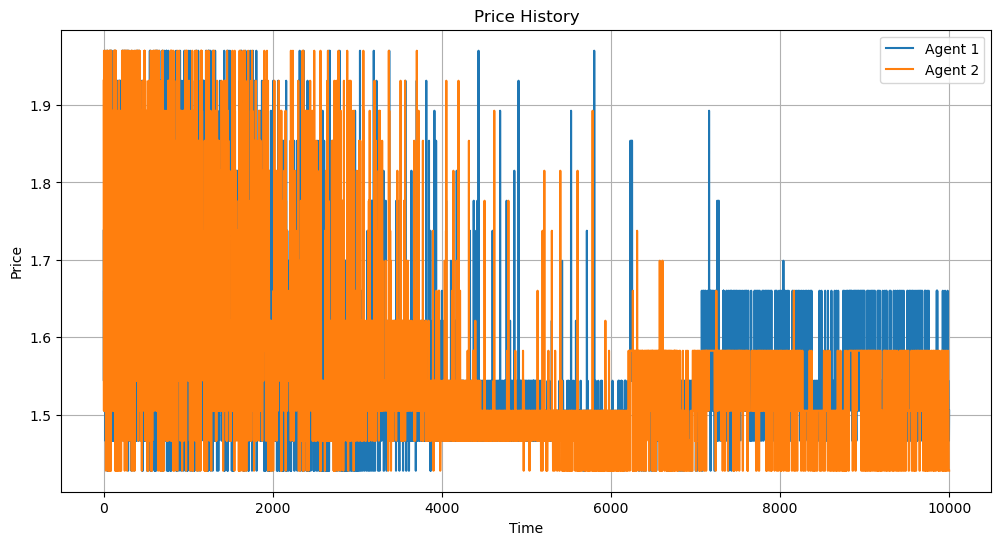

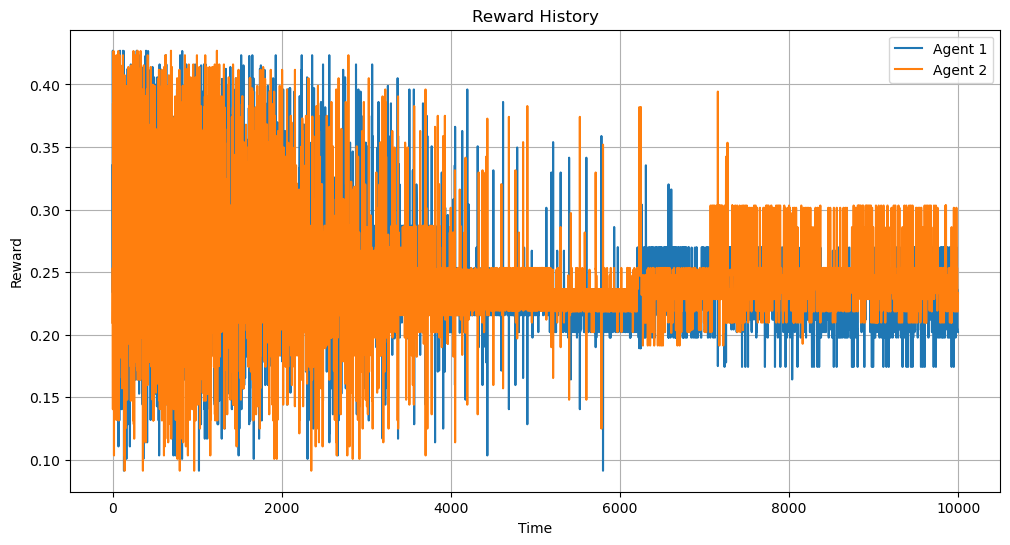

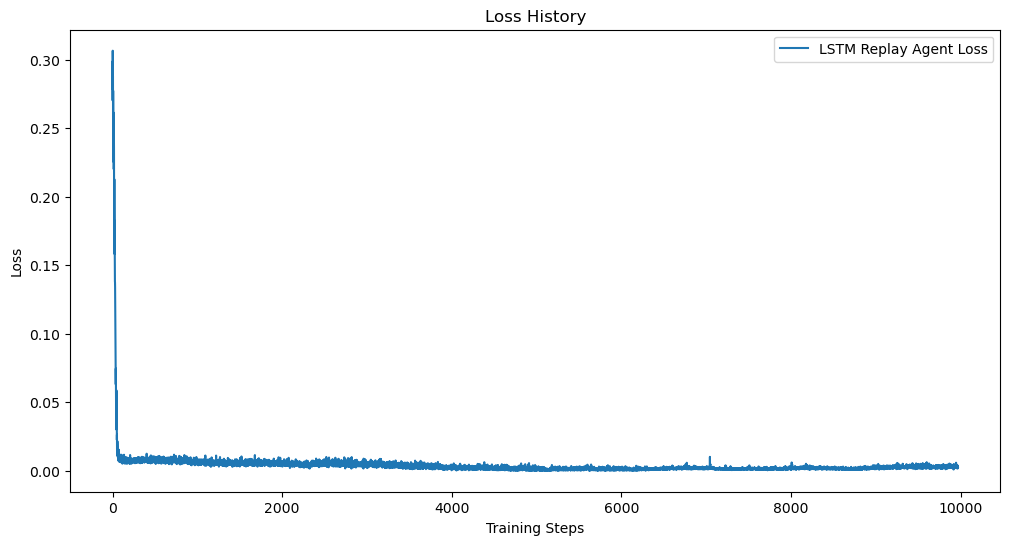

In [100]:
import pickle

import matplotlib.pyplot as plt

# Load the data from the file
file_name = "lstm_replay_agent_data.pkl"

with open(file_name, "rb") as f:
	data = pickle.load(f)

# Extract price, reward, and loss histories
price_history = data["price_history"]
reward_history = data["reward_history"]
loss_history = data["loss_history"]

indexRange = slice(None, None)
# Plot price history
plt.figure(figsize=(12, 6))
for agent_idx in range(len(price_history[0])):  # Iterate over agents
	agent_prices = [prices[agent_idx] for prices in price_history]
	plt.plot(agent_prices[indexRange], label=f"Agent {agent_idx + 1}")
plt.title("Price History")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# Plot reward history
plt.figure(figsize=(12, 6))

for agent_idx in range(len(reward_history[0])):  # Iterate over agents
	agent_rewards = [rewards[agent_idx] for rewards in reward_history]
	plt.plot(agent_rewards[indexRange], label=f"Agent {agent_idx + 1}")
plt.title("Reward History")
plt.xlabel("Time")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()

# Plot loss history
plt.figure(figsize=(12, 6))
plt.plot(loss_history[indexRange], label="LSTM Replay Agent Loss")
plt.title("Loss History")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()



# Multiple runs, Multiprocessing

In [28]:
import random
import numpy as np
import torch

def set_seed(seed: int):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [29]:
from datetime import datetime
import pickle
from concurrent.futures import ThreadPoolExecutor

def run_simulation(simulation_id, output_file_prefix="simulation", seed=None):
    """Run a single simulation and save the results."""
    if seed is not None:
        set_seed(seed + simulation_id)  # Use a unique seed for each simulation

    print(f"Running simulation {simulation_id} with seed {seed + simulation_id if seed is not None else 'None'}...")

    # Set up the environment
    env = DiscreteSynchronEnvironment(
        markup=0.1,
        n_periods=100_000,
        possible_prices=[],
        n_prices=15,
        demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
        history_after=0,
        agents=[
            LSTMReplayAgent(
                discount=0.999,
                learning_rate=0.001,
                decision=DecreasingEpsilonGreedy(),
                marginal_cost=1.0,
                quality=2.0,
                sequence_length=15,
                batch_size=32,
                replay_buffer_capacity=500,
            ),
            LSTMReplayAgent(
                discount=0.999,
                learning_rate=0.001,
                decision=DecreasingEpsilonGreedy(),
                marginal_cost=1.0,
                quality=2.0,
                sequence_length=15,
                batch_size=32,
                replay_buffer_capacity=500,
            ),
        ],
    )

    # Run the simulation
    env.play_game()

    # Collect data for this run
    run_data = {
        "run_id": simulation_id,
        "parameters": {
            "environment": {
                "markup": env.markup,
                "n_periods": env.n_periods,
                "n_prices": env.n_prices,
                "demand": {
                    "type": type(env.demand).__name__,
                    "outside_quality": getattr(env.demand, "outside_quality", None),
                    "price_sensitivity": getattr(env.demand, "price_sensitivity", None),
                },
            },
            "agents": [
                {
                    "type": type(agent).__name__,
                    "discount": getattr(agent, "discount", None),
                    "learning_rate": getattr(agent, "learning_rate", None),
                    "sequence_length": getattr(agent, "sequence_length", None),
                    "batch_size": getattr(agent, "batch_size", None),
                    "use_soft_update": getattr(agent, "use_soft_update", None),
                    "TAU": getattr(agent, "TAU", None),
                    "marginal_cost": getattr(agent, "marginal_cost", None),
                    "quality": getattr(agent, "quality", None),
                    "replay_buffer_capacity": getattr(agent, "replay_buffer_capacity", None),
                }
                for agent in env.agents
            ],
        },
        "histories": {
            "prices": getattr(env, "price_history", None),
            "quantities": getattr(env, "quantity_history", None),
            "rewards": getattr(env, "reward_history", None),
        },
    }

    # Save the run data to a file
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"{output_file_prefix}_{timestamp}_run_{simulation_id}.pkl"
    with open(output_file, "wb") as f:
        pickle.dump(run_data, f)

    print(f"Simulation {simulation_id} saved to {output_file}")



In [30]:
import torch.multiprocessing as mp

cpu_count = os.cpu_count()
def run_multiple_simulations_parallel(n_runs=10, max_workers=cpu_count, output_file_prefix="simulation_results", base_seed=200):
    """Run multiple simulations in parallel and save all results to a single file with a timestamp."""

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(run_simulation, i + 1, output_file_prefix, base_seed) for i in range(n_runs)]

    print(f"All simulations completed."),

# Run 10 simulations in parallel using available CPU cores
run_multiple_simulations_parallel(n_runs=10, max_workers=cpu_count)

Running simulation 1 with seed 201...Running simulation 9 with seed 209...

Running simulation 2 with seed 202...
Running simulation 8 with seed 208...
Running simulation 4 with seed 204...
Running simulation 5 with seed 205...
Running simulation 10 with seed 210...
Running simulation 7 with seed 207...
Running simulation 3 with seed 203...
Running simulation 6 with seed 206...
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 75000/100000
Period 75000/100000
Period 75000/100000

In [31]:
import pickle
import glob

# Define the pattern to match files dynamically
file_pattern = "simulation_results_20250430_*run*.pkl"

# Get the list of files matching the pattern
files_to_merge = sorted(glob.glob(file_pattern))

# Initialize an empty list to store merged data
merged_data = []

# Load and merge data from each file
for file in files_to_merge:
	with open(file, 'rb') as f:
		data = pickle.load(f)
		merged_data.append(data)

# Save the merged data to a new file
# Extract the yearMonthDay_Hour part from the file pattern
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Use the extracted timestamp to create the output file name
output_file = f'merged_simulation_results_{timestamp}.pkl'
with open(output_file, 'wb') as f:
	pickle.dump(merged_data, f)

print(f"Merged {len(files_to_merge)} files to {output_file}")


Merged 10 files to merged_simulation_results_20250430_111608.pkl


## Analysis

In [34]:
import pickle
import numpy as np

import matplotlib.pyplot as plt

# file name
file_path = "full_simulation_alwaysMax.pkl"
# Load the merged simulation results
with open(file_path, "rb") as f:
	merged_data = pickle.load(f)

# Extract price histories from all runs
price_histories = [run["histories"]["prices"] for run in merged_data]
reward_history = [run["histories"]["rewards"] for run in merged_data]

# Convert price histories to a 3D numpy array (runs x periods x agents)
all_prices = np.array(price_histories)
all_rewards = np.array(reward_history)

# Ensure all_prices is 3D
if all_prices.ndim != 3:
	raise ValueError("Expected 'all_prices' to be a 3D array (runs x periods x agents).")
if all_rewards.ndim != 3:
	raise ValueError("Expected 'all_prices' to be a 3D array (runs x periods x agents).")

# Number of agents
n_agents = all_prices.shape[2]


In [35]:
run_paramters = [run["parameters"] for run in merged_data][0]
run_paramters

{'environment': {'markup': 0.1,
  'n_periods': 10000,
  'n_prices': 15,
  'demand': {'type': 'LogitDemand',
   'outside_quality': 0.0,
   'price_sensitivity': 0.25}},
 'agents': [{'type': 'LSTMReplayAgent',
   'discount': 0.95,
   'learning_rate': 0.001,
   'sequence_length': 15,
   'batch_size': 32,
   'use_soft_update': True,
   'TAU': 0.01,
   'marginal_cost': 1.0,
   'quality': 2.0},
  {'type': 'AlwaysMaxAgent',
   'discount': None,
   'learning_rate': None,
   'sequence_length': None,
   'batch_size': None,
   'use_soft_update': None,
   'TAU': None,
   'marginal_cost': 1.0,
   'quality': 2.0}]}

### Performance Measures
According to Agarwal et al (2021), https://proceedings.neurips.cc/paper_files/paper/2021/file/f514cec81cb148559cf475e7426eed5e-Paper.pdf


In [36]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

In [37]:
all_prices.shape # (10 x 10000 x 2), (runs x periods x agents)

(10, 9999, 2)

In [38]:
prices_agent_1 = all_prices[:, :, 0]
print(f"Mean: {metrics.aggregate_mean(prices_agent_1)}")
print(f"Median: {metrics.aggregate_median(prices_agent_1)}")
print(f"IQM: {metrics.aggregate_iqm(prices_agent_1)}")


Mean: 1.6778288652429467
Median: 1.6718305386500543
IQM: 1.671614465259687


### Plotting Prequisites

In [39]:
# Initialize the EquilibriumCalculator with the demand model
run_demand=run_paramters["environment"]["demand"]
run_demand = LogitDemand(
	price_sensitivity=run_paramters["environment"]["demand"]["price_sensitivity"],
	outside_quality=run_paramters["environment"]["demand"]["outside_quality"]
	)
equilibrium_calculator = EquilibriumCalculator(demand=run_demand)

# Define qualities and marginal costs for the agents
qualities = [agent["quality"] for agent in run_paramters["agents"]]
marginal_costs = [agent["marginal_cost"] for agent in run_paramters["agents"]]

# Calculate Nash equilibrium prices
nash_prices = equilibrium_calculator.get_nash_equilibrium(qualities, marginal_costs)

# Calculate monopoly (cooperation) prices
monopoly_prices = equilibrium_calculator.get_monopoly_outcome(qualities, marginal_costs)

# Calculate Nash equilibrium profit
nash_quantities = logit_demand.get_quantities(nash_prices, qualities)
nash_profits = [-equilibrium_calculator.profit(
	nash_prices[i], nash_prices, qualities, marginal_costs, i
	) for i in range(2)]


# Calculate cooperation (monopoly) profit
monopoly_quantities = logit_demand.get_quantities(monopoly_prices, qualities)
monopoly_profits = [-equilibrium_calculator.profit(
	monopoly_prices[i], monopoly_prices, qualities, marginal_costs, i
	) for i in range(2)]

# Print the results
print("Nash Equilibrium Prices:", nash_prices)
print("Nash Equilibrium Profits:", nash_profits)
print("Cooperation (Monopoly) Prices:", monopoly_prices)
print("Cooperation (Monopoly) Profits:", monopoly_profits)


Nash Equilibrium Prices: [1.47292666 1.47292666]
Nash Equilibrium Profits: [0.22292666184720236, 0.22292666184720236]
Cooperation (Monopoly) Prices: [1.92498092 1.92498091]
Cooperation (Monopoly) Profits: [0.3374904540309753, 0.3374904649867865]


In [40]:
def compute_normalized_profit(observed_profits, nash_profits, monopoly_profits):
    """
    Computes the normalized profit measure Δ for multiple agents.

    Args:
        observed_profits (list or np.ndarray): The observed profits (π̅) for each agent.
        nash_profits (list or np.ndarray): The Nash equilibrium profits (πⁿ) for each agent.
        monopoly_profits (list or np.ndarray): The Monopoly profits (πᵐ) for each agent.

    Returns:
        list: The normalized profit measures Δ for each agent.
    """
    if len(observed_profits) != len(nash_profits) or len(nash_profits) != len(monopoly_profits):
        raise ValueError("All input arrays must have the same length.")

    deltas = []
    for observed, nash, monopoly in zip(observed_profits, nash_profits, monopoly_profits):
        if monopoly == nash:
            raise ValueError("Monopoly profit and Nash profit cannot be equal for any agent.")
        delta = (observed - nash) / (monopoly - nash)
        deltas.append(delta)

    return deltas

example_profits = [0.19122466, 0.2609135]
compute_normalized_profit(
	example_profits, nash_profits, monopoly_profits
)


[-0.2767192080753479, 0.3315780125290938]

### Plot prices of runs

ToDo
* Metric for plotting: IQM
* smooth out trajectory
* measure: profit gain: Calvano p.3277

In [41]:
# Normalize the all_rewards array
normalized_rewards = np.zeros_like(all_rewards)

for run_idx in range(all_rewards.shape[0]):  # Iterate over runs
    for agent_idx in range(all_rewards.shape[2]):  # Iterate over agents
        # Extract observed profits for the current agent in the current run
        observed_profits = all_rewards[run_idx, :, agent_idx]
        
        # Compute normalized profits for the current agent
        normalized_rewards[run_idx, :, agent_idx] = compute_normalized_profit(
            observed_profits, 
            [nash_profits[agent_idx]] * len(observed_profits), 
            [monopoly_profits[agent_idx]] * len(observed_profits)
        )

print("Normalized rewards shape:", normalized_rewards.shape)

Normalized rewards shape: (10, 9999, 2)


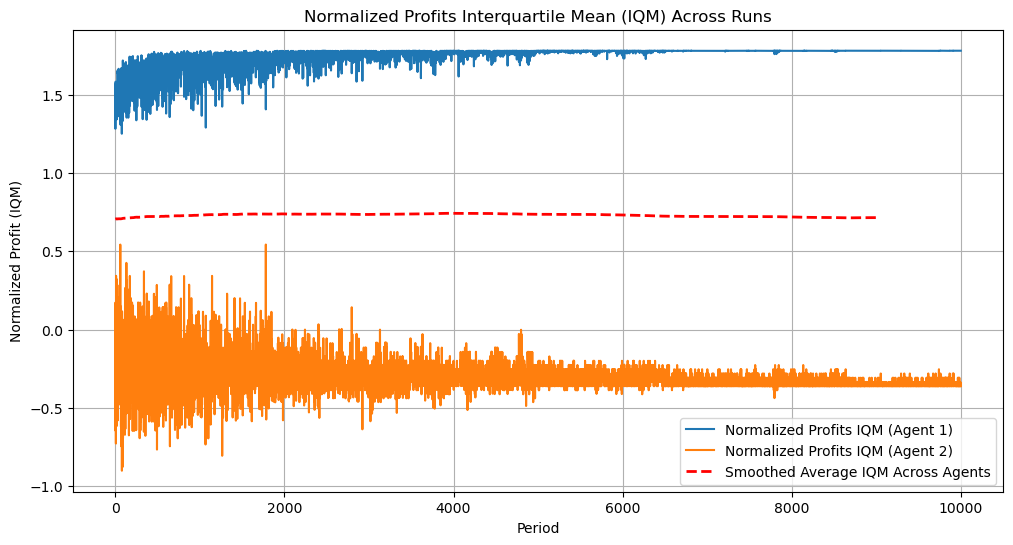

In [42]:
import numpy as np
from scipy.stats import trim_mean

import matplotlib.pyplot as plt

# Extract reward histories from all runs
reward_histories = [run["histories"]["rewards"] for run in merged_data]

# Convert reward histories to a 3D numpy array (runs x periods x agents)
all_rewards = np.array(reward_histories)

# Normalize the all_rewards array
normalized_rewards = np.zeros_like(all_rewards)

for run_idx in range(all_rewards.shape[0]):  # Iterate over runs
    for agent_idx in range(all_rewards.shape[2]):  # Iterate over agents
        # Extract observed profits for the current agent in the current run
        observed_profits = all_rewards[run_idx, :, agent_idx]
        
        # Compute normalized profits for the current agent
        normalized_rewards[run_idx, :, agent_idx] = compute_normalized_profit(
            observed_profits, 
            [nash_profits[agent_idx]] * len(observed_profits), 
            [monopoly_profits[agent_idx]] * len(observed_profits)
        )

normalized_iqm_profits = trim_mean(normalized_rewards, proportiontocut=0.25, axis=0)
avg_price_across_agents = np.mean(normalized_iqm_profits, axis=1)

# Plot the IQM of normalized profits across runs
plt.figure(figsize=(12, 6))
plt.plot(normalized_iqm_profits[:, 0], label="Normalized Profits IQM (Agent 1)")
plt.plot(normalized_iqm_profits[:, 1], label="Normalized Profits IQM (Agent 2)")
# Smooth the average price across agents using a moving average
window_size = 1000
smoothed_avg_price = np.convolve(avg_price_across_agents, np.ones(window_size)/window_size, mode='valid')
# Plot the smoothed average price
plt.plot(smoothed_avg_price, label="Smoothed Average IQM Across Agents", linestyle='--', color='r', linewidth=2)
plt.title("Normalized Profits Interquartile Mean (IQM) Across Runs")
plt.xlabel("Period")
plt.ylabel("Normalized Profit (IQM)")
plt.legend()
plt.grid()
plt.show()

In [43]:
np.mean(normalized_iqm_profits, axis=1).shape

(9999,)

In [44]:
# Plot delta for stable prices at the end of the simulation

print(f"final Δ: {np.mean(normalized_iqm_profits[-2000:, :])}")

final Δ: 0.7173877861334447


### Unadjusted Plots

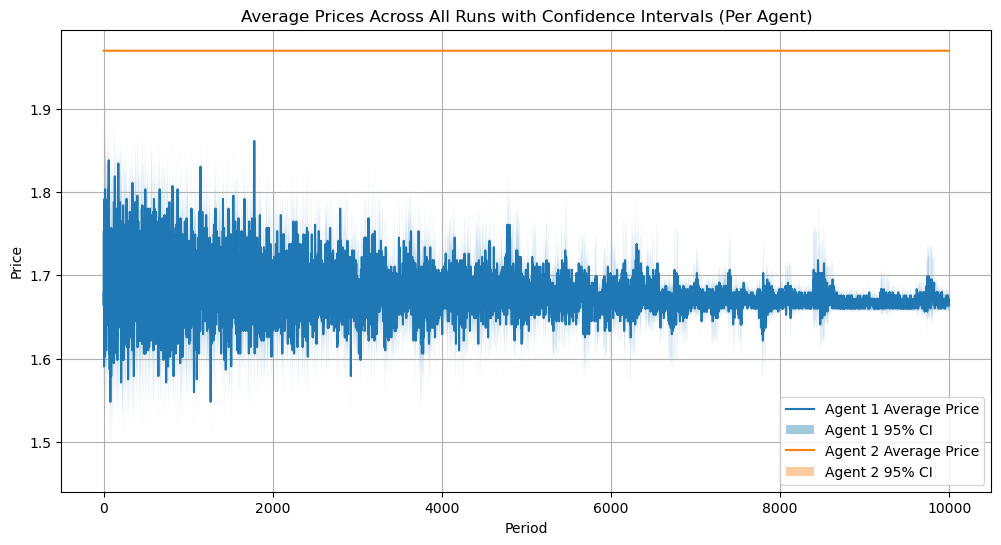

In [45]:

# Plot average prices with confidence intervals for each agent
plt.figure(figsize=(12, 6))

for agent_idx in range(n_agents):
	# Extract prices for the current agent
	agent_prices = all_prices[:, :, agent_idx]  # Shape: (runs x periods)

	# Calculate average prices for each period across all runs
	average_prices = np.mean(agent_prices, axis=0)

	# Calculate the 95% confidence interval
	# CI = 1.96 * (standard deviation / sqrt(number of runs))
	std_prices = np.std(agent_prices, axis=0)
	n_runs = agent_prices.shape[0]
	confidence_interval = 1.96 * (std_prices / np.sqrt(n_runs))

	# Plot average prices with confidence interval for the current agent
	plt.plot(average_prices, label=f"Agent {agent_idx + 1} Average Price")
	plt.fill_between(
		range(len(average_prices)),
		average_prices - confidence_interval,
		average_prices + confidence_interval,
		alpha=0.4,
		label=f"Agent {agent_idx + 1} 95% CI"
	)

# Add plot details
plt.title("Average Prices Across All Runs with Confidence Intervals (Per Agent)")
plt.xlabel("Period")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

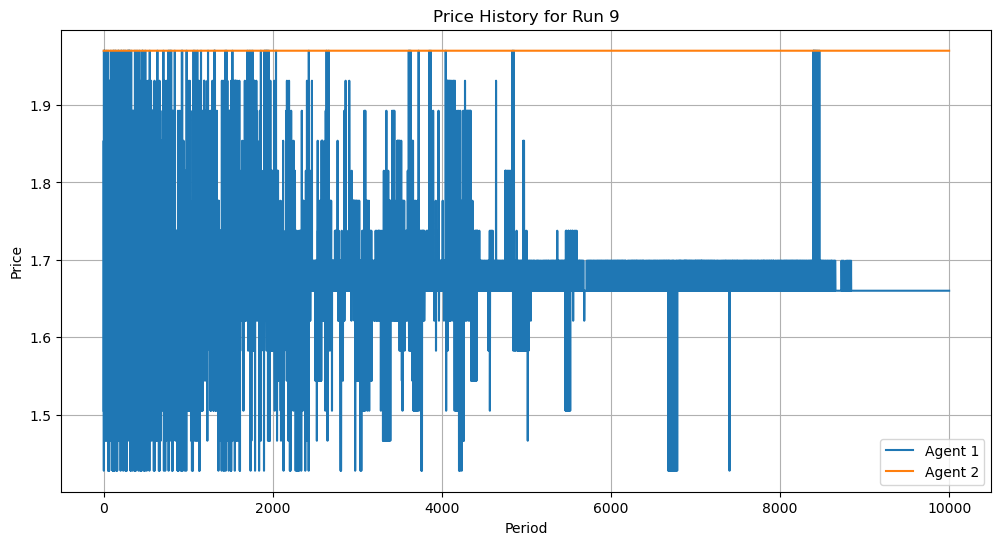

In [46]:
# Select a specific run
run_index = 8
single_run_prices = price_histories[run_index]

# Plot the price history for the selected run
plt.figure(figsize=(12, 6))
for agent_idx in range(len(single_run_prices[0])):  # Iterate over agents
	agent_prices = [prices[agent_idx] for prices in single_run_prices[:]]
	plt.plot(agent_prices[:], label=f"Agent {agent_idx + 1}")
plt.title(f"Price History for Run {run_index + 1}")
plt.xlabel("Period")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# Deviation Analysis
## Training

In [ ]:
import torch
import pickle
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime

def train_lstm_agent(simulation_id, output_file_prefix="lstm_agent", seed=None):
	"""Train a single LSTM agent and save the model."""
	if seed is not None:
		set_seed(seed + simulation_id)  # Use a unique seed for each simulation

	print(f"Training LSTM agent {simulation_id} with seed {seed + simulation_id if seed is not None else 'None'}...")

	# Create an environment with two LSTMReplayAgents
	env = DiscreteSynchronEnvironment(
		markup=0.1,
		n_periods=100_000,
		possible_prices=[],
		n_prices=15,
		demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
		history_after=0,
		agents=[
			LSTMReplayAgent(
				discount=0.95,
				learning_rate=0.001,
				decision=DecreasingEpsilonGreedy(),
				marginal_cost=1.0,
				quality=2.0,
				sequence_length=15,
				batch_size=32,
				use_soft_update=True,
				TAU=0.001,
				replay_buffer_capacity=500,
			),
			LSTMReplayAgent(
				discount=0.95,
				learning_rate=0.001,
				decision=DecreasingEpsilonGreedy(),
				marginal_cost=1.0,
				quality=2.0,
				sequence_length=15,
				batch_size=32,
				use_soft_update=True,
				TAU=0.001,
				replay_buffer_capacity=500,
			),
		],
	)

	# Train the agents by simulating the environment
	env.play_game()

	# Save the trained models
	trained_models = {
		"agent_1": env.agents[0].lstm.state_dict(),
		"agent_2": env.agents[1].lstm.state_dict(),
	}
	timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
	model_file = f"{output_file_prefix}_{timestamp}_run_{simulation_id}.pth"
	torch.save(trained_models, model_file)
	print(f"Trained models for simulation {simulation_id} saved to {model_file}")

	# Save additional training data
	training_data = {
		"price_history": env.price_history,
		"reward_history": env.reward_history,
		"loss_history_agent_1": env.agents[0].loss_history,
		"loss_history_agent_2": env.agents[1].loss_history,
		"parameters": {
			"markup": env.markup,
			"n_periods": env.n_periods,
			"n_prices": env.n_prices,
			"demand": {
				"price_sensitivity": env.demand.price_sensitivity,
				"outside_quality": env.demand.outside_quality,
			},
			"agent_1": {
				"discount": env.agents[0].discount,
				"learning_rate": env.agents[0].learning_rate,
				"marginal_cost": env.agents[0].marginal_cost,
				"quality": env.agents[0].quality,
				"sequence_length": env.agents[0].sequence_length,
				"batch_size": env.agents[0].batch_size,
				"replay_buffer_capacity": env.agents[0].replay_buffer_capacity,
			},
			"agent_2": {
				"discount": env.agents[1].discount,
				"learning_rate": env.agents[1].learning_rate,
				"marginal_cost": env.agents[1].marginal_cost,
				"quality": env.agents[1].quality,
				"sequence_length": env.agents[1].sequence_length,
				"batch_size": env.agents[1].batch_size,
				"replay_buffer_capacity": env.agents[1].replay_buffer_capacity,
			},
		},
	}
	data_file = f"{output_file_prefix}_{timestamp}_run_{simulation_id}_data.pkl"
	with open(data_file, "wb") as f:
		pickle.dump(training_data, f)
	print(f"Training data for simulation {simulation_id} saved to {data_file}")


def train_multiple_agents_parallel(n_agents=10, max_workers=os.cpu_count(), output_file_prefix="lstm_agents", base_seed=200):
	"""Train multiple LSTM agents in parallel."""
	with ThreadPoolExecutor(max_workers=max_workers) as executor:
		futures = [executor.submit(train_lstm_agent, i + 1, output_file_prefix, base_seed) for i in range(n_agents)]

	print("All agents trained and saved.")


# Train 10 agents in parallel
train_multiple_agents_parallel(n_agents=10)

Training LSTM agent 3 with seed 203...Training LSTM agent 10 with seed 210...

Training LSTM agent 8 with seed 208...
Training LSTM agent 9 with seed 209...
Training LSTM agent 6 with seed 206...
Training LSTM agent 2 with seed 202...
Training LSTM agent 7 with seed 207...
Training LSTM agent 1 with seed 201...
Training LSTM agent 4 with seed 204...
Training LSTM agent 5 with seed 205...
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 75000/100000
Period 75000/100000
Period 75

## Merging

In [150]:
import pickle
import glob
from datetime import datetime

# Define the pattern to match files dynamically
file_pattern = "lstm_agents_*_run_*_data.pkl"

# Get the list of files matching the pattern
files_to_merge = sorted(glob.glob(file_pattern))

# Initialize an empty list to store merged data
merged_data = []

# Load and merge data from each file
for file in files_to_merge:
	with open(file, 'rb') as f:
		data = pickle.load(f)
		merged_data.append(data)

# Save the merged data to a new file
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = f'trained_lstm_agents_data_{timestamp}.pkl'
with open(output_file, 'wb') as f:
	pickle.dump(merged_data, f)

print(f"Merged {len(files_to_merge)} files to {output_file}")

Merged 10 files to trained_lstm_agents_data_20250430_165638.pkl


## Loading

In [29]:
import pickle

# Load the data from the file
file_name = "trained_lstm_agents_data_20250430_165638.pkl"

with open(file_name, "rb") as f:
	trained_data = pickle.load(f)

# Display the keys in the loaded data
print("Keys in the loaded data:", trained_data[0].keys())

Keys in the loaded data: dict_keys(['price_history', 'reward_history', 'loss_history_agent_1', 'loss_history_agent_2'])


### Plotting Prequisites

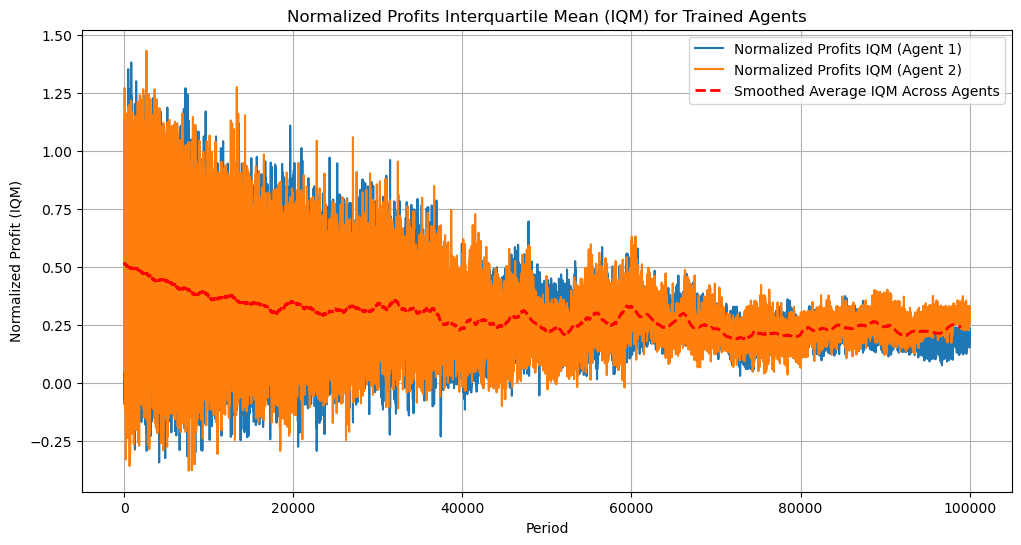

In [47]:
import numpy as np
from scipy.stats import trim_mean

import matplotlib.pyplot as plt

# Extract reward histories from the trained data
reward_histories = [run["reward_history"] for run in trained_data]

# Convert reward histories to a 3D numpy array (runs x periods x agents)
all_rewards = np.array(reward_histories)

# Normalize the all_rewards array
normalized_rewards = np.zeros_like(all_rewards)

for run_idx in range(all_rewards.shape[0]):  # Iterate over runs
	for agent_idx in range(all_rewards.shape[2]):  # Iterate over agents
		# Extract observed profits for the current agent in the current run
		observed_profits = all_rewards[run_idx, :, agent_idx]
		
		# Compute normalized profits for the current agent
		normalized_rewards[run_idx, :, agent_idx] = compute_normalized_profit(
			observed_profits, 
			[nash_profits[agent_idx]] * len(observed_profits), 
			[monopoly_profits[agent_idx]] * len(observed_profits)
		)

# Compute the IQM of normalized profits across runs
normalized_iqm_profits = trim_mean(normalized_rewards, proportiontocut=0.25, axis=0)
avg_normalized_iqm = np.mean(normalized_iqm_profits, axis=1)

# Smooth the IQM using a moving average
window_size = 1000
smoothed_normalized_iqm_profits = np.convolve(avg_normalized_iqm, np.ones(window_size)/window_size, mode='valid')

# Plot the IQM of normalized profits
plt.figure(figsize=(12, 6))
plt.plot(normalized_iqm_profits[:, 0], label="Normalized Profits IQM (Agent 1)")
plt.plot(normalized_iqm_profits[:, 1], label="Normalized Profits IQM (Agent 2)")
plt.plot(smoothed_normalized_iqm_profits, label="Smoothed Average IQM Across Agents", linestyle='--', color='r', linewidth=2)
plt.title("Normalized Profits Interquartile Mean (IQM) for Trained Agents")
plt.xlabel("Period")
plt.ylabel("Normalized Profit (IQM)")
plt.legend()
plt.grid()
plt.show()

relatively stable runs: 2 and 9

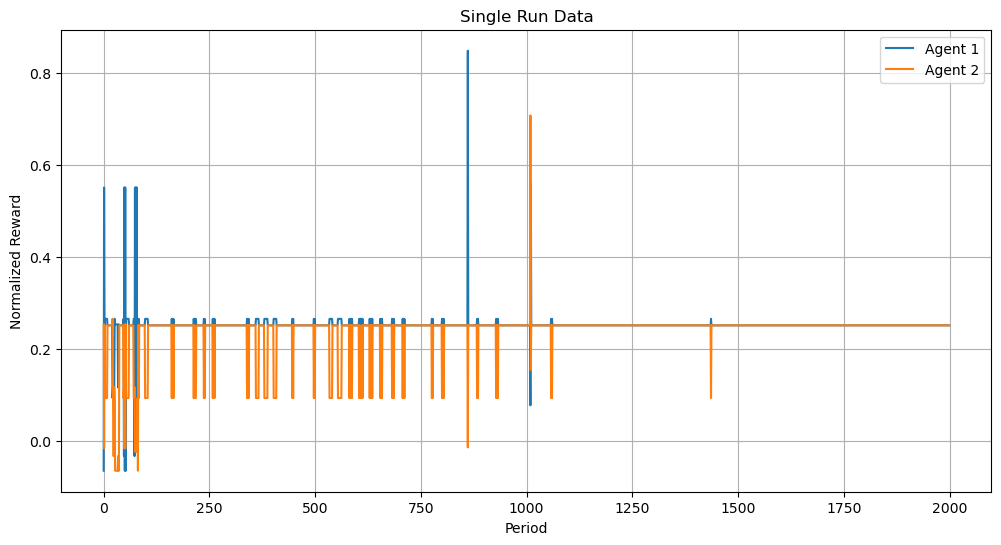

In [88]:
single_run_data = normalized_rewards[9, -2000:, :]
plt.figure(figsize=(12, 6))
for agent_idx in range(single_run_data.shape[1]):  # Iterate over agents
	plt.plot(single_run_data[:, agent_idx], label=f"Agent {agent_idx + 1}")
plt.title("Single Run Data")
plt.xlabel("Period")
plt.ylabel("Normalized Reward")
plt.legend()
plt.grid()
plt.show()



### Load Agents

In [162]:
import torch

trained_prices = []
trained_rewards = []
final_action_values = []

# iterate over trained agents
for i in range(10):
	# Load the trained models from the .pth file
	model_file = "trained_lstm_20250430_run_9.pth"  # Replace with the correct file name
	trained_models = torch.load(model_file)

	# Initialize the LSTM models and load the state dictionaries
	agent_1_lstm = LSTMModel(input_size=2, hidden_size=32, output_size=15)  # Adjust parameters as needed
	agent_2_lstm = LSTMModel(input_size=2, hidden_size=32, output_size=15)  # Adjust parameters as needed

	agent_1_lstm.load_state_dict(trained_models["agent_1"])
	agent_2_lstm.load_state_dict(trained_models["agent_2"])

	# Set the models to evaluation mode and disable gradient computation
	agent_1_lstm.eval()
	agent_2_lstm.eval()

	for param in agent_1_lstm.parameters():
		param.requires_grad = False

	for param in agent_2_lstm.parameters():
		param.requires_grad = False

	print("Trained LSTM models loaded and learning disabled.")



	# Create an environment with two LSTMReplayAgents
	deviation_env = DiscreteSynchronEnvironment(
		markup=0.1,
		n_periods=50,
		possible_prices=[],
		n_prices=15,
		demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
		history_after=0,
		agents=[
			LSTMReplayAgent(
				lstm=agent_1_lstm,
				disable_learning=True,
				discount=0.95,
				learning_rate=0.001,
				decision=DecreasingEpsilonGreedy(),
				marginal_cost=1.0,
				quality=2.0,
				sequence_length=15,
				batch_size=32,
				use_soft_update=True,
				TAU=0.001,
				replay_buffer_capacity=500,
			),
			LSTMReplayAgent(
				lstm=agent_2_lstm,
				disable_learning=True,
				discount=0.95,
				learning_rate=0.001,
				decision=DecreasingEpsilonGreedy(),
				marginal_cost=1.0,
				quality=2.0,
				sequence_length=15,
				batch_size=32,
				use_soft_update=True,
				TAU=0.001,
				replay_buffer_capacity=500,
			),
		],
	)

	# Simulate the environment for 50 periods
	deviation_env.play_game()

	# Extract price history for each agent
	trained_prices.append(deviation_env.price_history)
	trained_rewards.append(deviation_env.reward_history)

	state_input = np.array(deviation_env.price_history)[-15:, :]
	state_input = deviation_env.agents[0].scale_sequence(state_input, deviation_env.possible_prices)
	state_input = torch.from_numpy(state_input).float().unsqueeze(0)  # Add batch dimension
	output_agent_1, output_agent_2 = agent_1_lstm(state_input), agent_2_lstm(state_input)

	# Convert action values to numpy arrays for plotting
	action_values_agent_1 = output_agent_1.detach().numpy().flatten()
	action_values_agent_2 = output_agent_2.detach().numpy().flatten()

	final_action_values.append(np.array([action_values_agent_1, action_values_agent_2]))

Trained LSTM models loaded and learning disabled.
Period 0/50
Period 12/50
Period 24/50
Period 36/50
Period 48/50
Trained LSTM models loaded and learning disabled.
Period 0/50
Period 12/50
Period 24/50
Period 36/50
Period 48/50
Trained LSTM models loaded and learning disabled.
Period 0/50
Period 12/50
Period 24/50
Period 36/50
Period 48/50
Trained LSTM models loaded and learning disabled.
Period 0/50
Period 12/50
Period 24/50
Period 36/50
Period 48/50
Trained LSTM models loaded and learning disabled.
Period 0/50
Period 12/50
Period 24/50
Period 36/50
Period 48/50
Trained LSTM models loaded and learning disabled.
Period 0/50
Period 12/50
Period 24/50
Period 36/50
Period 48/50
Trained LSTM models loaded and learning disabled.
Period 0/50
Period 12/50
Period 24/50
Period 36/50
Period 48/50
Trained LSTM models loaded and learning disabled.
Period 0/50
Period 12/50
Period 24/50
Period 36/50
Period 48/50
Trained LSTM models loaded and learning disabled.
Period 0/50
Period 12/50
Period 24/50


## Play again

In [201]:
np.array(trained_rewards).shape # (10 x 50 x 2), (runs x periods x agents)

(10, 49, 2)

Mean: [0.25092589 0.25553482]
Median: [0.25167713 0.25167713]
IQM: 0.25167713002390985


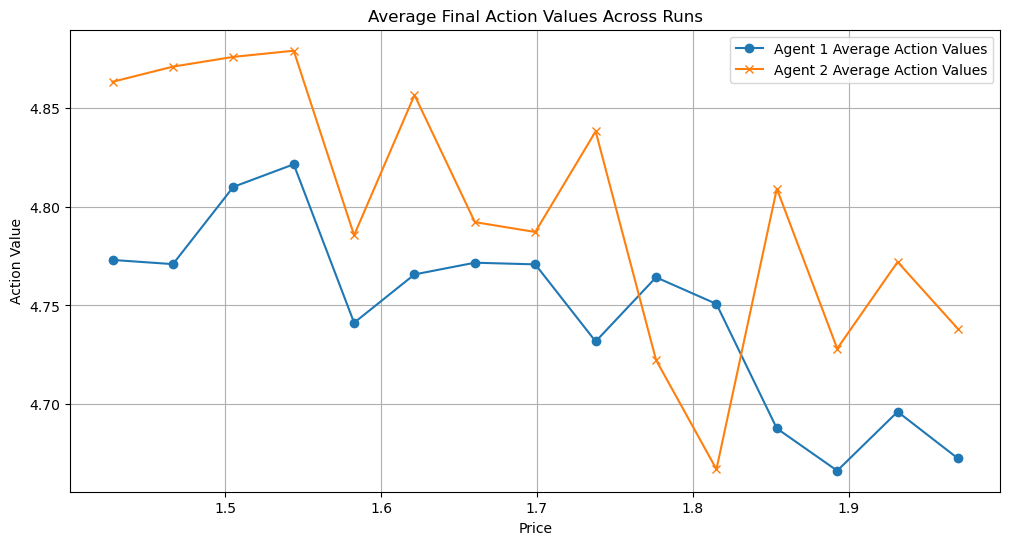

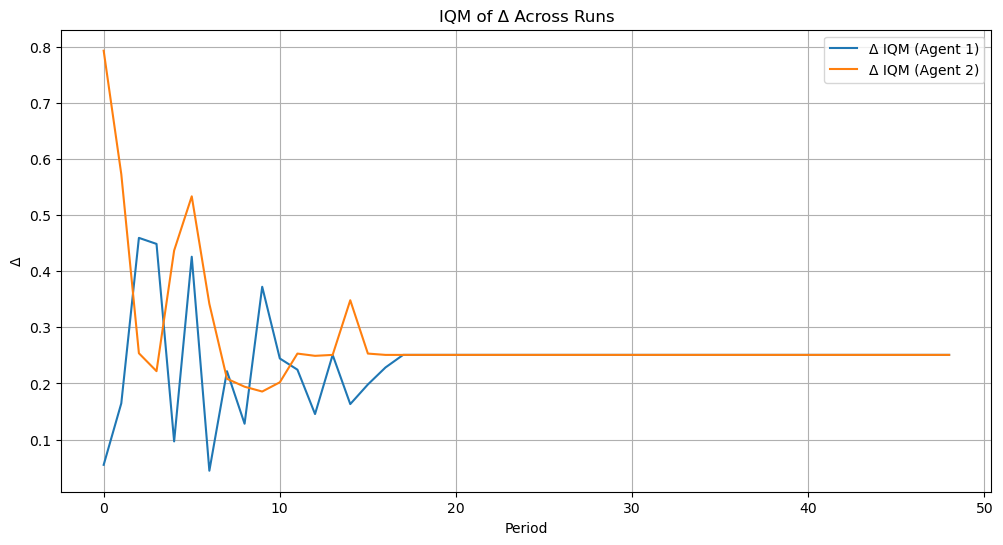

In [209]:
from rliable import metrics
print(f"Mean: {metrics.aggregate_mean(trained_rewards)}")
print(f"Median: {metrics.aggregate_median(trained_rewards)}")
print(f"IQM: {metrics.aggregate_iqm(trained_rewards)}")

np.array(final_action_values)
# Convert final_action_values to a numpy array for easier manipulation
final_action_values_array = np.array(final_action_values)

# Calculate the average action values across runs for each agent
average_action_values_agent_1 = final_action_values_array[:, 0, :].mean(axis=0)
average_action_values_agent_2 = final_action_values_array[:, 1, :].mean(axis=0)

# Plot the average action values for both agents
plt.figure(figsize=(12, 6))
plt.plot(deviation_env.possible_prices, average_action_values_agent_1, label="Agent 1 Average Action Values", marker='o')
plt.plot(deviation_env.possible_prices, average_action_values_agent_2, label="Agent 2 Average Action Values", marker='x')
plt.title("Average Final Action Values Across Runs")
plt.xlabel("Price")
plt.ylabel("Action Value")
plt.legend()
plt.grid()
plt.show()

# Normalize the trained_rewards array
normalized_trained_rewards = np.zeros_like(trained_rewards)

for run_idx in range(len(trained_rewards)):  # Iterate over runs
	for agent_idx in range(len(trained_rewards[run_idx][0])):  # Iterate over agents
		# Extract observed profits for the current agent in the current run
		observed_profits = np.array([reward[agent_idx] for reward in trained_rewards[run_idx]])
		
		# Compute normalized profits for the current agent
		normalized_trained_rewards[run_idx, :, agent_idx] = compute_normalized_profit(
			observed_profits, 
			[nash_profits[agent_idx]] * len(observed_profits), 
			[monopoly_profits[agent_idx]] * len(observed_profits)
		)

# Compute the IQM of normalized profits across runs
normalized_iqm_trained_rewards = trim_mean(normalized_trained_rewards, proportiontocut=0.25, axis=0)
avg_normalized_iqm_trained = np.mean(normalized_iqm_trained_rewards, axis=1)

# Smooth the IQM using a moving average
window_size = 100
smoothed_normalized_iqm_trained = np.convolve(avg_normalized_iqm_trained, np.ones(window_size)/window_size, mode='valid')

# Plot the IQM of normalized profits
plt.figure(figsize=(12, 6))
plt.plot(normalized_iqm_trained_rewards[:, 0], label="Δ IQM (Agent 1)")
plt.plot(normalized_iqm_trained_rewards[:, 1], label="Δ IQM (Agent 2)")
plt.title("IQM of Δ Across Runs")
plt.xlabel("Period")
plt.ylabel("Δ")
plt.legend()
plt.grid()
plt.show()

Period 0/50
Period 12/50
Period 24/50
Period 36/50
Period 48/50


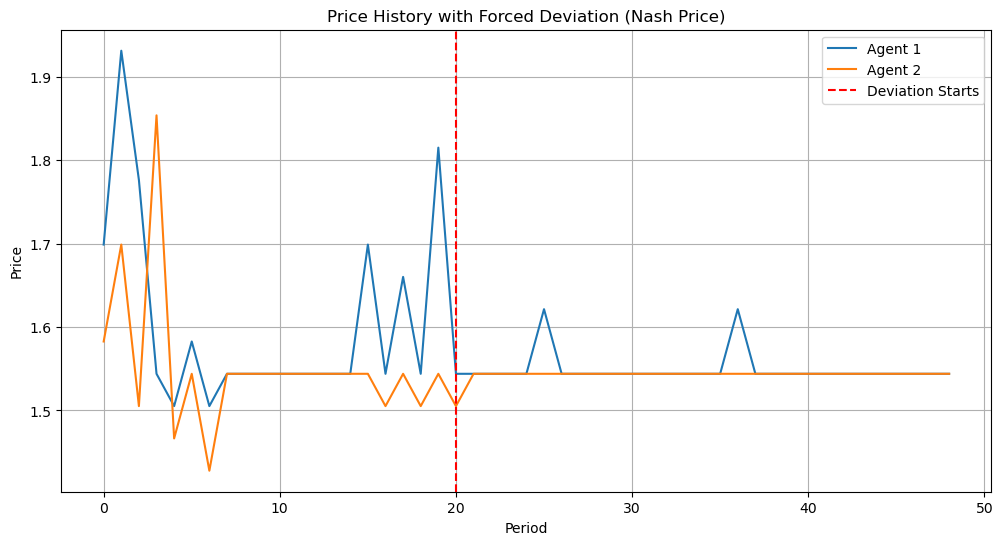

In [235]:
import copy
import matplotlib.pyplot as plt

# Create a custom environment with forced deviation
class DeviationEnvironment(DiscreteSynchronEnvironment):
    def __init__(self, *args, deviation_start_period=30, deviation_duration=1, deviating_agent_idx=0, **kwargs):
        super().__init__(*args, **kwargs)
        self.deviation_start_period = deviation_start_period
        self.deviation_duration = deviation_duration
        self.deviating_agent_idx = deviating_agent_idx
        self.original_play_price = None

    def play_game(self) -> int:
        # Backup the original play_price method of the deviating agent
        self.original_play_price = self.agents[self.deviating_agent_idx].play_price

        # Get the Nash price for the deviating agent
        deviation_price = self.nash_prices[self.deviating_agent_idx]

        # Override the play_price method for the deviation period
        def forced_deviation_play_price(state, action_space, n_period, t):
            if self.deviation_start_period <= t < self.deviation_start_period + self.deviation_duration:
                return deviation_price
            else:
                # Revert to the original play_price method after the deviation period
                self.agents[self.deviating_agent_idx].play_price = self.original_play_price
                return self.original_play_price(state, action_space, n_period, t)

        self.agents[self.deviating_agent_idx].play_price = forced_deviation_play_price

        # Run the game
        return super().play_game()

# Set a random seed for reproducibility
set_seed(201)

# Example usage
deviation_env = DeviationEnvironment(
    markup=0.1,
    n_periods=50,
    possible_prices=[],
    n_prices=15,
    demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
    history_after=0,
    agents=[
        LSTMReplayAgent(
            lstm=agent_1_lstm,  # Pre-trained LSTM model
            disable_learning=True,
            discount=0.95,
            learning_rate=0.001,
            decision=DecreasingEpsilonGreedy(),
            marginal_cost=1.0,
            quality=2.0,
            sequence_length=15,
            batch_size=32,
            use_soft_update=True,
            TAU=0.001,
            replay_buffer_capacity=500,
        ),
        LSTMReplayAgent(
            lstm=agent_2_lstm,  # Pre-trained LSTM model
            disable_learning=True,
            discount=0.95,
            learning_rate=0.001,
            decision=DecreasingEpsilonGreedy(),
            marginal_cost=1.0,
            quality=2.0,
            sequence_length=15,
            batch_size=32,
            use_soft_update=True,
            TAU=0.001,
            replay_buffer_capacity=500,
        ),
    ],
    deviation_start_period=20,  # Start deviation at period 30
    deviation_duration=1,  # Deviation lasts for 1 period
    deviating_agent_idx=0,  # Index of the deviating agent
)

# Simulate the environment
deviation_env.play_game()

# Analyze the results
price_history = deviation_env.price_history
reward_history = deviation_env.reward_history

# Plot the price history
plt.figure(figsize=(12, 6))
for agent_idx in range(len(price_history[0])):
    agent_prices = [prices[agent_idx] for prices in price_history]
    plt.plot(agent_prices, label=f"Agent {agent_idx + 1}")
plt.axvline(x=deviation_env.deviation_start_period, color='r', linestyle='--', label="Deviation Starts")
plt.title("Price History with Forced Deviation (Nash Price)")
plt.xlabel("Period")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()